## Utilization calculation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
import csv
from tabulate import tabulate

def utilization_calc(rho_df, obj):
    rho_df.drop(columns=['stat'], inplace=True)
    interarrival_df = rho_df[rho_df['metric'] == 'interarrival']
    service_df = rho_df[rho_df['metric'] == 'service']

    interarrival_df = interarrival_df.rename(columns={'value': 'interarrival'})
    service_df = service_df.rename(columns={'value': 'service'})

    interarrival_df = interarrival_df.drop(columns=['metric'])
    service_df = service_df.drop(columns=['metric'])
    rho_df = pd.merge(interarrival_df, service_df, on=['lambda', 'node', 'iteration'], how='inner', validate='one_to_one')
    rho_df['utilization'] = rho_df['service'] / rho_df['interarrival']

    rho_df = rho_df[['iteration','lambda','node','interarrival','service','utilization']]
    rho_df.to_csv(os.path.join('output',f'{obj}_rho.csv'), index=False)
    rho_df = rho_df.rename(columns={'utilization': 'value'})
    rho_df['metric'] = 'utilization'
    rho_list = []
    for node in rho_df['node'].unique():
        node_df = rho_df[rho_df['node'] == node]
        rho_list.append(node_df)
    return rho_list

## Preprocessing


All csv files containing run statistics are read and a single dataframe is created with the concatenated csvs by adding a 'lambda' column with the arrival rate values. Three other columns are extracted from the 'statistic' column: 'node' containing the reference node of the statistic or system if it is global, 'metric' indicating the measured metric and finally 'stat' specifying whether the measured value is mean, minimum, maximum or standard deviation.

Finally, a list of dataframes is created one for each metric and node taking only the mean as the statistic.

In [2]:
output_path = os.path.join(".", "output")
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Function to remove outliers based on Z-score
def remove_outliers_zscore(df, column, threshold=3):
    z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())
    return df[z_scores <= threshold]

def preprocessing(path, obj):
    filenames = os.listdir(path)
    stats_df_list = []
    for i in filenames:
        lambda_val = i.split('=')[1].split('_')[0]
        stats_path = os.path.join(path, i)
        stats_df = pd.read_csv(stats_path)
        stats_df['lambda'] = lambda_val
        stats_df_list.append(stats_df)
    stats_df = pd.concat(stats_df_list)

    stats_df['node'] = stats_df['statistic'].apply(lambda x: x.split('-')[0])
    stats_df['metric'] = stats_df['statistic'].apply(lambda x: x.split('-')[1])
    stats_df['stat'] = stats_df['statistic'].apply(lambda x: x.split('-')[2])
    stats_df.drop(columns=['statistic'], inplace=True)

    stats_df = stats_df[stats_df['stat'] == 'avg']
    utilization_df = stats_df[stats_df['metric'] == 'interarrival']
    utilization_df = pd.concat([stats_df[stats_df['metric'] == 'service'], utilization_df])
    
    # List of one DataFrame for each metric selecting only the average as statistic
    metrics = stats_df['metric'].unique()
    metrics_avg_df_list = []
    metrics = metrics[metrics != 'interarrival']
    metrics = metrics[metrics != 'service']
    
    for i in metrics:
        metrics_avg_df = stats_df[stats_df['metric'] == i]
        
        # Remove outliers for the 'value' column (or other numerical columns)
        if 'value' in metrics_avg_df.columns:
            metrics_avg_df = remove_outliers_zscore(metrics_avg_df, 'value')
        
        metrics_avg_df_list.append(metrics_avg_df)

    metrics_nodes_avg_df_list = []
    for i in metrics_avg_df_list:
        nodes = i['node'].unique()
        node_avg_df_list = []
        for j in nodes:
            node_avg_df = i[i['node'] == j]
            node_avg_df_list.append(node_avg_df)
        metrics_nodes_avg_df_list.append(node_avg_df_list)
    metrics_nodes_avg_df_list.append(utilization_calc(utilization_df, obj))
    return metrics_nodes_avg_df_list


## Boxplot funcion
Boxplots of the average of population number, throughput and response time with arrival rate in a range 0.5, 1.2 job/sec

In [3]:
def boxplot(metrics_nodes_avg_df_list):    
    for metric in metrics_nodes_avg_df_list:
        figure, axis = plt.subplots(2, 2, figsize=(15, 10))
        for i, boxplot_df in enumerate(metric):
            boxplot_df['value'].astype(float)
            boxplot_df['lambda'].astype(float)
            boxplot_df = boxplot_df.sort_values(by='lambda')

            curr_metric = boxplot_df['metric'].unique()[0]
            curr_node = boxplot_df['node'].unique()[0]
            x = i // 2
            y = i % 2

            boxplot_df.boxplot(column='value', by='lambda', ax = axis[x, y], showfliers=False)
            plt.suptitle('')
            axis[x, y].set_title(f'Boxplot of {curr_metric} of the {curr_node} node')

        plt.tight_layout()
        plt.show()

## Confidence interval calculation
Confidence intervals are calculated on the batches of runs made as the lambda parameter changes.

The following formula is used to calculate the interval:

$
CI = \bar{x} \pm z \cdot \frac{\sigma}{\sqrt{n}}
$

Where:
- $\bar{x}$ is the sample mean.
- $z$ is the critical value of the standard normal distribution corresponding to the chosen confidence level (e.g., 1.96 for 95%).
- $\sigma$ is the population standard deviation.
- $n$ is the sample size.

In [4]:
def confidence_interval(metrics_nodes_avg_df_list, critical_value, obj):
    ci_df = []
    for metric in metrics_nodes_avg_df_list:
        metric_list = []
        for node_df in metric:
            curr_metric = node_df['metric'].unique()[0]
            curr_node = node_df['node'].unique()[0]
            
            df = node_df.groupby(["lambda"])['value'].describe()[["count", "mean", "std"]].reset_index()
            df["lower_ci"] = df["mean"] - critical_value*(df["std"]/np.sqrt(df["count"]))
            df["upper_ci"] = df["mean"] + critical_value*(df["std"]/np.sqrt(df["count"]))

            df.to_csv(os.path.join("output", f"{obj}_conf_int_{curr_node}_{curr_metric}.csv"), index=False)
            df['metric'] = curr_metric
            df['node'] = curr_node
            metric_list.append(df)
        ci_df.append(metric_list)
    return ci_df

In [5]:
def plot_confidence_interval(ci_df):
    for metric in ci_df:
        fig, axis = plt.subplots(2, 2, figsize=(15, 10))
        for i, df in enumerate(metric):
            x = i // 2
            y = i % 2

            # error bar plot with mean point
            up = df['upper_ci'] - df['mean']
            low = df['mean'] - df['lower_ci']
            axis[x, y].errorbar(df['lambda'], df['mean'], yerr=[low, up], fmt='o', capsize=5, label='Confidence interval 95%')

            # lineplot of the mean points
            axis[x, y].plot(df['lambda'], df['mean'], linestyle='-', marker='o', color='b', label='Avg')

            axis[x, y].set_xlabel('Lambda')
            axis[x, y].set_ylabel(f"Avg {df['metric'].unique()[0]} in {df['node'].unique()[0]}")
            axis[x, y].set_title(f"Confidence interval for {df['node'].unique()[0]} average {df['metric'].unique()[0]}")
            axis[x, y].legend()
        plt.tight_layout()
        plt.show()


## Simulation vs. Analitycal model

In [54]:
def analitycal_preprocessing(obj):
    metric_node_analitycal_list = []
    local_perf = pd.read_csv(os.path.join('output', f'{obj}_analitycal_local_performances.csv'))
    global_perf = pd.read_csv(os.path.join('output', f'{obj}_analitycal_global_performances.csv'))
    rho_perf = pd.read_csv(os.path.join('output', f'{obj}_analitycal_rho.csv'))
    analitycal_perf = pd.merge(local_perf, global_perf, on=['gamma'], how='inner', validate='one_to_one')
    analitycal_perf = pd.merge(analitycal_perf, rho_perf, on=['gamma'], how='inner', validate='one_to_one')

    response_time_columns = [col for col in analitycal_perf.columns if col.startswith('E[T]')]
    population_columns = [col for col in analitycal_perf.columns if col.startswith('E[N]')]
    utilization_columns = [col for col in analitycal_perf.columns if col.startswith('rho')]
    throughput_columns = [col for col in analitycal_perf.columns if col.startswith('X')]

    rt_df = analitycal_perf[response_time_columns].copy()
    rt_df['metric'] = 'response_time'
    np_df = analitycal_perf[population_columns].copy()
    np_df['metric'] =  'population'
    ut_df = analitycal_perf[utilization_columns].copy()
    ut_df['metric'] =  'utilization'
    tp_df = analitycal_perf[throughput_columns].copy()
    tp_df['metric'] =  'throughput'

    metric_list = [rt_df, np_df, ut_df, tp_df]
    for metric in metric_list:
        node_list = []
        a_column = [col for col in metric.columns if col.endswith('[A]')]
        b_column = [col for col in metric.columns if col.endswith('[B]')]
        p_column = [col for col in metric.columns if col.endswith('[P]')]
        
        a_df = metric[a_column].copy()
        a_df = a_df.rename(columns={a_column[0]: 'value'})
        a_df['node'] = 'A'
        a_df['lambda'] = analitycal_perf['gamma'].copy()
        a_df['metric'] = metric['metric'].unique()[0]

        b_df = metric[b_column].copy()
        b_df = b_df.rename(columns={b_column[0]: 'value'})
        b_df['node'] = 'B'
        b_df['lambda'] = analitycal_perf['gamma'].copy()
        b_df['metric'] = metric['metric'].unique()[0]

        p_df = metric[p_column].copy()
        p_df = p_df.rename(columns={p_column[0]: 'value'})
        p_df['node'] = 'P'
        p_df['lambda'] = analitycal_perf['gamma'].copy()
        p_df['metric'] = metric['metric'].unique()[0]

        node_list = [a_df, b_df, p_df]
        metric_node_analitycal_list.append(node_list)

    return metric_node_analitycal_list


def average_stats(stats_df, obj):
    avg_metric_list = []
    analytical_perf = analitycal_preprocessing(obj)
    for metric in stats_df:
        average_list_node = []
        for node_df in metric:
            node_df = node_df.groupby(['lambda', 'metric', 'node'])['value'].mean()
            average_list_node.append(node_df)
        avg_metric_list.append(average_list_node)
    return avg_metric_list

In [55]:
path = os.path.join("..", "..", "src", "caballo", "domestico", "wwsimulator", "statistics", "objective_1")
metrics_nodes_avg_df_list = preprocessing(path, 'obj1')
metric_node_analitycal = analitycal_preprocessing('obj_1')
print(metric_node_analitycal[0][0])

       value node  lambda         metric
0   0.230769    A    0.50  response_time
1   0.239044    A    0.55  response_time
2   0.247934    A    0.60  response_time
3   0.257511    A    0.65  response_time
4   0.267857    A    0.70  response_time
5   0.279070    A    0.75  response_time
6   0.291262    A    0.80  response_time
7   0.304569    A    0.85  response_time
8   0.319149    A    0.90  response_time
9   0.335196    A    0.95  response_time
10  0.352941    A    1.00  response_time
11  0.372671    A    1.05  response_time
12  0.394737    A    1.10  response_time
13  0.419580    A    1.15  response_time
14  0.447761    A    1.20  response_time


In [19]:
avg_metrics_list = average_stats(metrics_nodes_avg_df_list, 'obj_1')
for metric in avg_metrics_list:
    for node in metric:
        df = node.reset_index()
        display(tabulate(df, headers='keys', tablefmt='html', showindex=False))

lambda,metric,node,value
0.5,population,SYSTEM,1.9307
0.55,population,SYSTEM,2.0977
0.6,population,SYSTEM,2.4137
0.65,population,SYSTEM,2.6377
0.7,population,SYSTEM,3.0648
0.75,population,SYSTEM,3.3815
0.8,population,SYSTEM,3.7051
0.85,population,SYSTEM,4.40293
0.9,population,SYSTEM,4.62443
0.95,population,SYSTEM,5.31031


lambda,metric,node,value
0.5,population,A,1.0374
0.55,population,A,1.09667
0.6,population,A,1.21163
0.65,population,A,1.2646
0.7,population,A,1.4225
0.75,population,A,1.54647
0.8,population,A,1.69303
0.85,population,A,1.88597
0.9,population,A,2.04147
0.95,population,A,2.35427


lambda,metric,node,value
0.5,population,B,1.1624
0.55,population,B,1.2224
0.6,population,B,1.4077
0.65,population,B,1.5404
0.7,population,B,1.7597
0.75,population,B,1.9372
0.8,population,B,2.0765
0.85,population,B,2.5942
0.9,population,B,2.72828
0.95,population,B,3.0204


lambda,metric,node,value
0.5,population,P,0.7447
0.55,population,P,0.7626
0.6,population,P,0.809
0.65,population,P,0.8316
0.7,population,P,0.8727
0.75,population,P,0.9042
0.8,population,P,0.9535
0.85,population,P,0.9889
0.9,population,P,1.0208
0.95,population,P,1.0985


lambda,metric,node,value
0.5,response_time,A,0.361378
0.55,response_time,A,0.368563
0.6,response_time,A,0.402206
0.65,response_time,A,0.407651
0.7,response_time,A,0.449199
0.75,response_time,A,0.477819
0.8,response_time,A,0.517856
0.85,response_time,A,0.561153
0.9,response_time,A,0.591095
0.95,response_time,A,0.665424


lambda,metric,node,value
0.5,response_time,B,1.33506
0.55,response_time,B,1.37876
0.6,response_time,B,1.51572
0.65,response_time,B,1.62951
0.7,response_time,B,1.82392
0.75,response_time,B,1.96444
0.8,response_time,B,2.03763
0.85,response_time,B,2.52282
0.9,response_time,B,2.56942
0.95,response_time,B,2.77112


lambda,metric,node,value
0.5,response_time,P,0.499206
0.55,response_time,P,0.500988
0.6,response_time,P,0.520153
0.65,response_time,P,0.527215
0.7,response_time,P,0.556748
0.75,response_time,P,0.569304
0.8,response_time,P,0.586533
0.85,response_time,P,0.59116
0.9,response_time,P,0.612569
0.95,response_time,P,0.656739


lambda,metric,node,value
0.5,response_time,SYSTEM,2.9184
0.55,response_time,SYSTEM,2.98544
0.6,response_time,SYSTEM,3.24249
0.65,response_time,SYSTEM,3.37967
0.7,response_time,SYSTEM,3.72827
0.75,response_time,SYSTEM,3.9672
0.8,response_time,SYSTEM,4.17774
0.85,response_time,SYSTEM,4.58832
0.9,response_time,SYSTEM,4.77097
0.95,response_time,SYSTEM,5.29801


lambda,metric,node,value
0.5,throughput,A,13.9449
0.55,throughput,A,14.4102
0.6,throughput,A,17.2014
0.65,throughput,A,18.5073
0.7,throughput,A,29.1632
0.75,throughput,A,25.0867
0.8,throughput,A,25.8329
0.85,throughput,A,23.931
0.9,throughput,A,23.3738
0.95,throughput,A,25.1523


lambda,metric,node,value
0.5,throughput,B,5.35481
0.55,throughput,B,7.99541
0.6,throughput,B,9.26084
0.65,throughput,B,5.91885
0.7,throughput,B,8.42475
0.75,throughput,B,6.14712
0.8,throughput,B,9.83363
0.85,throughput,B,6.76225
0.9,throughput,B,9.71736
0.95,throughput,B,9.14028


lambda,metric,node,value
0.5,throughput,P,7.54105
0.55,throughput,P,4.31997
0.6,throughput,P,9.24394
0.65,throughput,P,6.63081
0.7,throughput,P,5.14456
0.75,throughput,P,10.0459
0.8,throughput,P,6.0797
0.85,throughput,P,16.617
0.9,throughput,P,10.2643
0.95,throughput,P,13.298


lambda,metric,node,value
0.5,throughput,SYSTEM,4.96397
0.55,throughput,SYSTEM,4.2469
0.6,throughput,SYSTEM,5.33968
0.65,throughput,SYSTEM,5.4718
0.7,throughput,SYSTEM,7.05436
0.75,throughput,SYSTEM,7.60712
0.8,throughput,SYSTEM,8.57518
0.85,throughput,SYSTEM,6.76453
0.9,throughput,SYSTEM,11.7877
0.95,throughput,SYSTEM,7.35059


lambda,metric,node,value
0.5,utilization,SYSTEM,0.156417
0.55,utilization,SYSTEM,0.179857
0.6,utilization,SYSTEM,0.213215
0.65,utilization,SYSTEM,0.237803
0.7,utilization,SYSTEM,0.2737
0.75,utilization,SYSTEM,0.315141
0.8,utilization,SYSTEM,0.371737
0.85,utilization,SYSTEM,0.422276
0.9,utilization,SYSTEM,0.473528
0.95,utilization,SYSTEM,0.557808


lambda,metric,node,value
0.5,utilization,A,0.546609
0.55,utilization,A,0.617913
0.6,utilization,A,0.727307
0.65,utilization,A,0.799967
0.7,utilization,A,0.947084
0.75,utilization,A,1.06246
0.8,utilization,A,1.23983
0.85,utilization,A,1.41164
0.9,utilization,A,1.58541
0.95,utilization,A,1.89818


lambda,metric,node,value
0.5,utilization,B,0.679275
0.55,utilization,B,0.781286
0.6,utilization,B,0.925085
0.65,utilization,B,1.08549
0.7,utilization,B,1.31531
0.75,utilization,B,1.50318
0.8,utilization,B,1.70276
0.85,utilization,B,2.22667
0.9,utilization,B,2.46058
0.95,utilization,B,2.91429


lambda,metric,node,value
0.5,utilization,P,0.252206
0.55,utilization,P,0.280895
0.6,utilization,P,0.314747
0.65,utilization,P,0.345637
0.7,utilization,P,0.393602
0.75,utilization,P,0.424166
0.8,utilization,P,0.470675
0.85,utilization,P,0.504682
0.9,utilization,P,0.545355
0.95,utilization,P,0.622956


## Objective 1

Implementation of a model to execute the web app workflow to measure response time (R), population number (N) and throughput (X) quantities

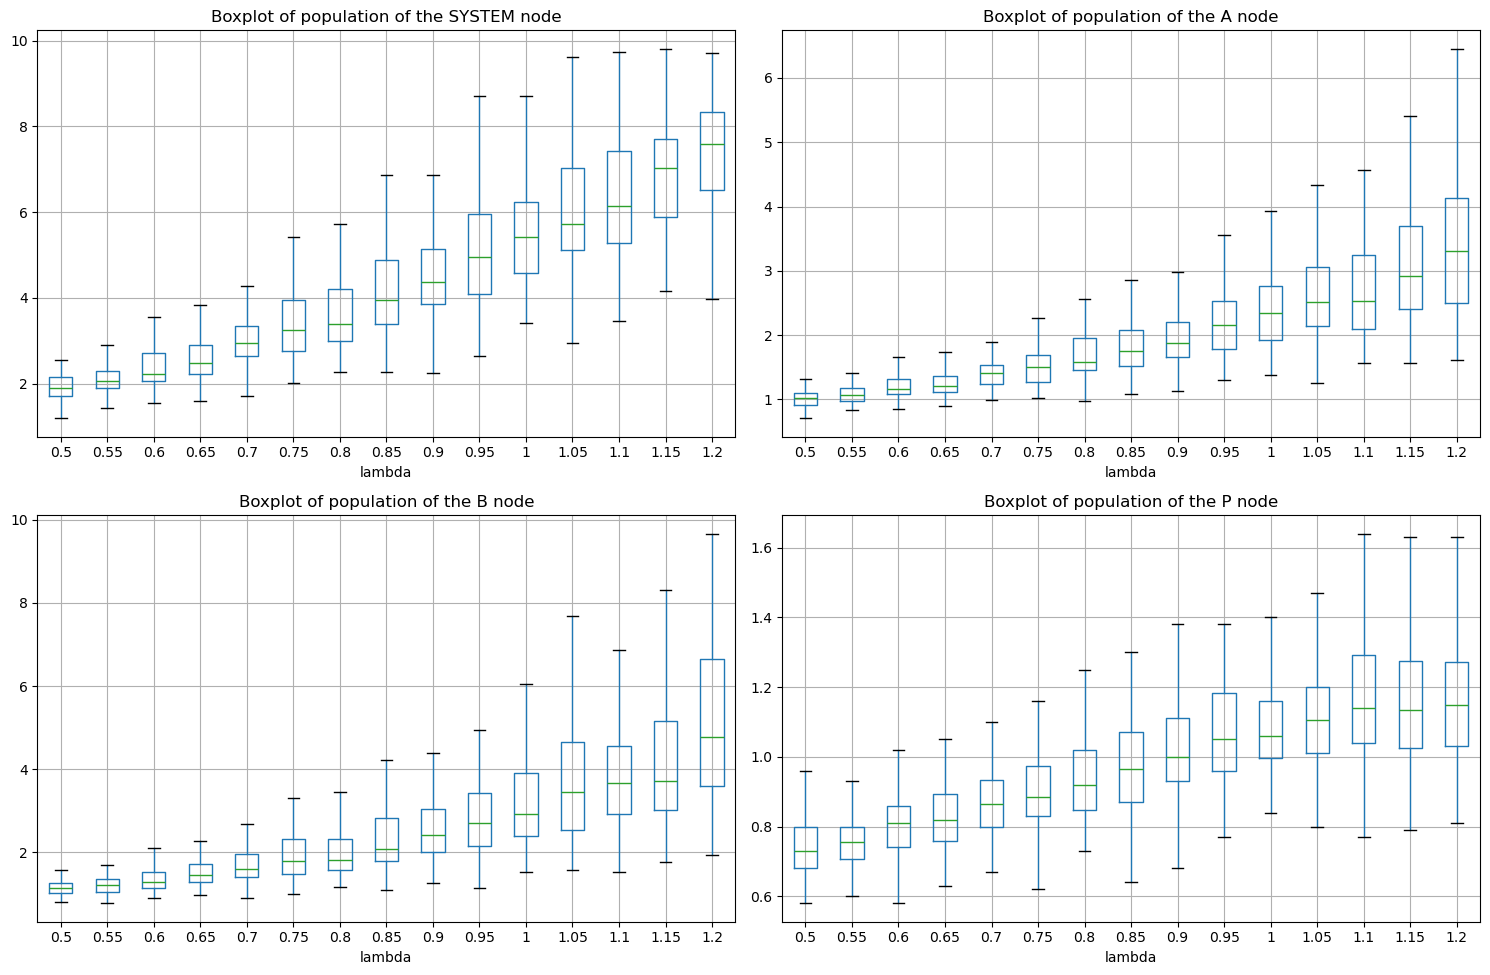

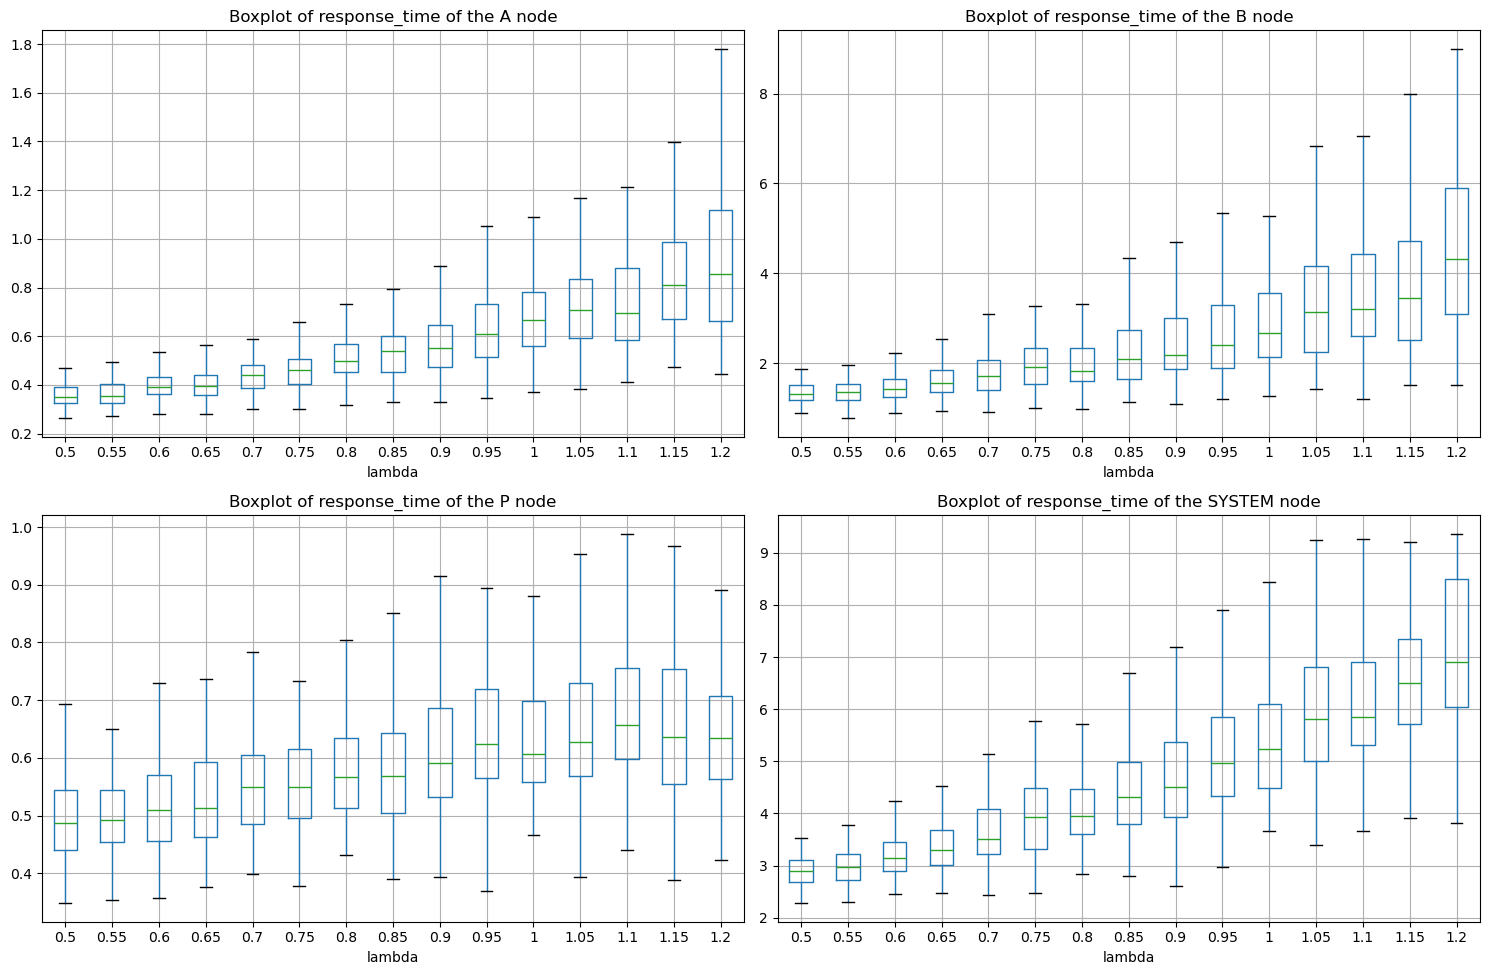

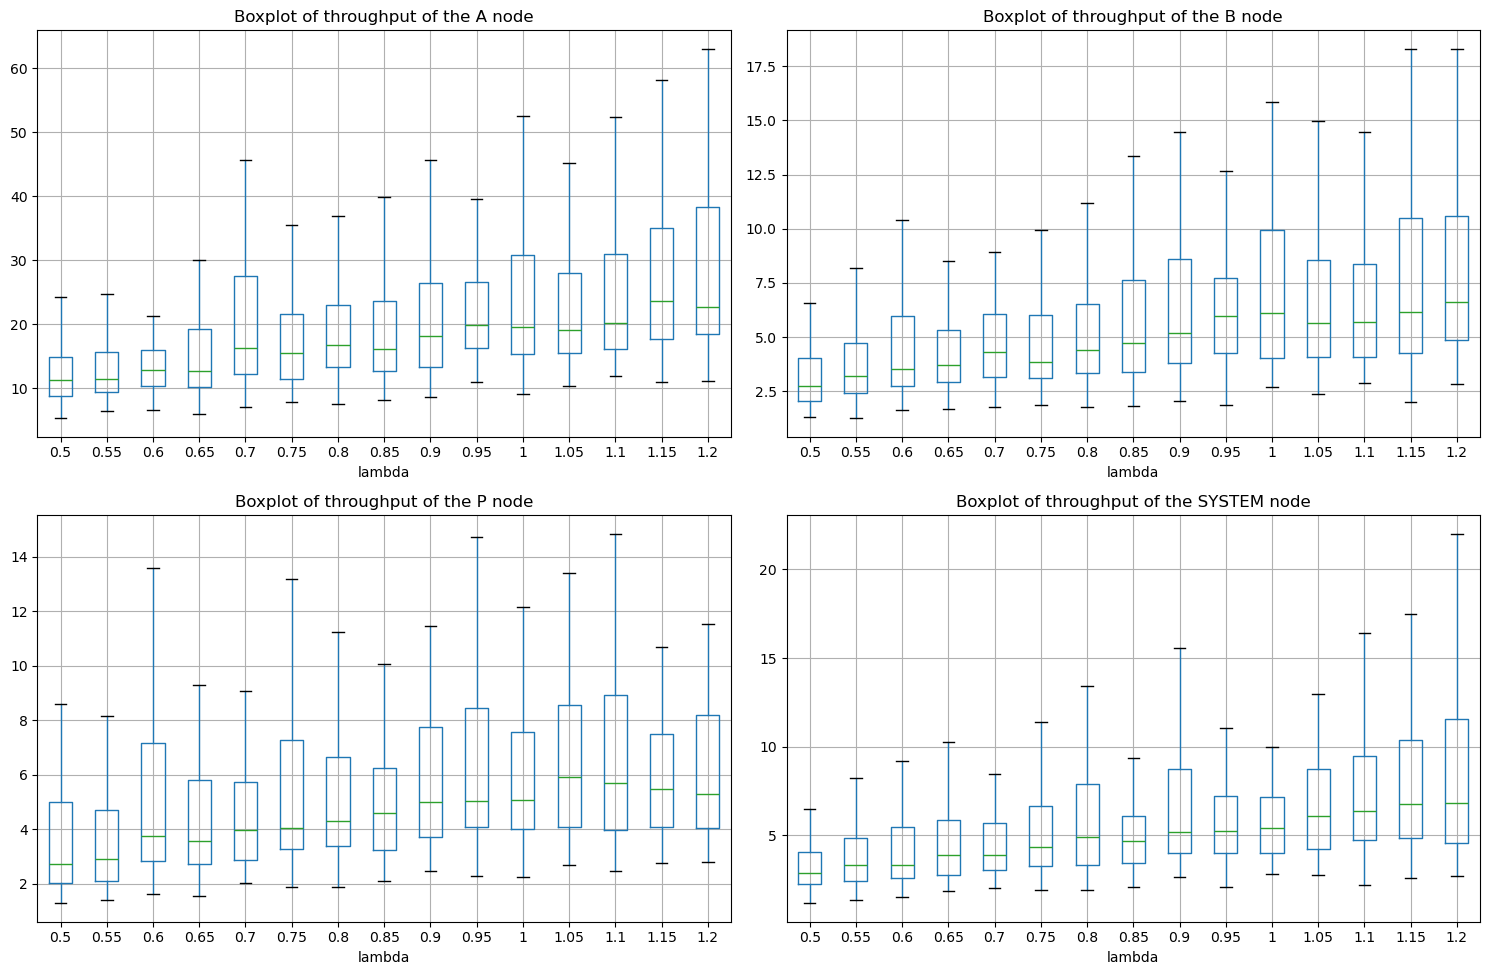

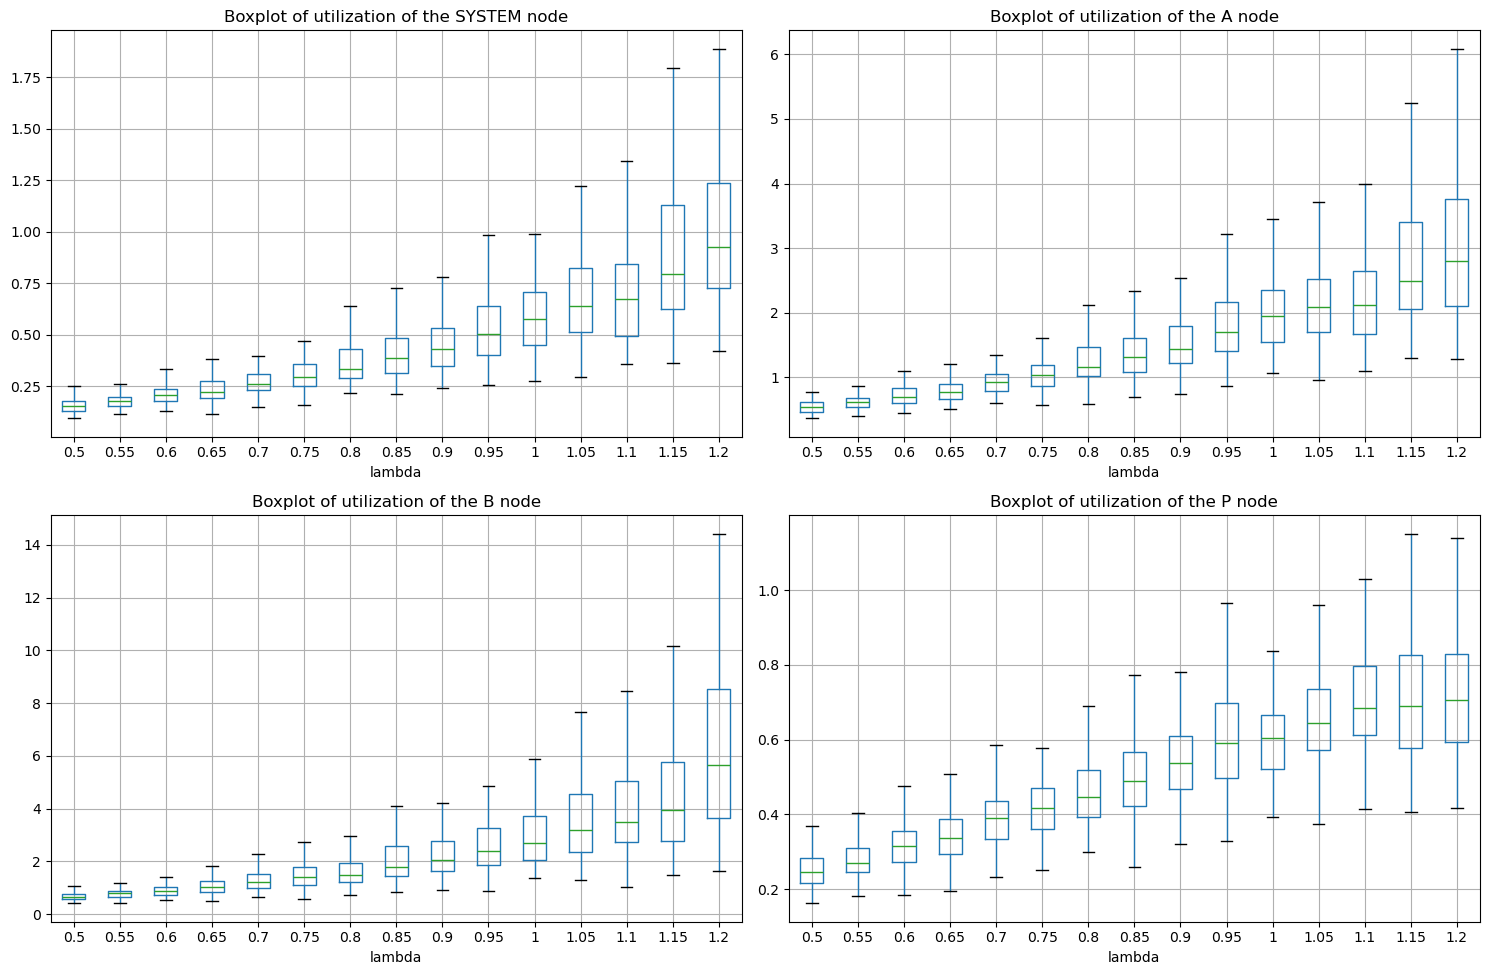

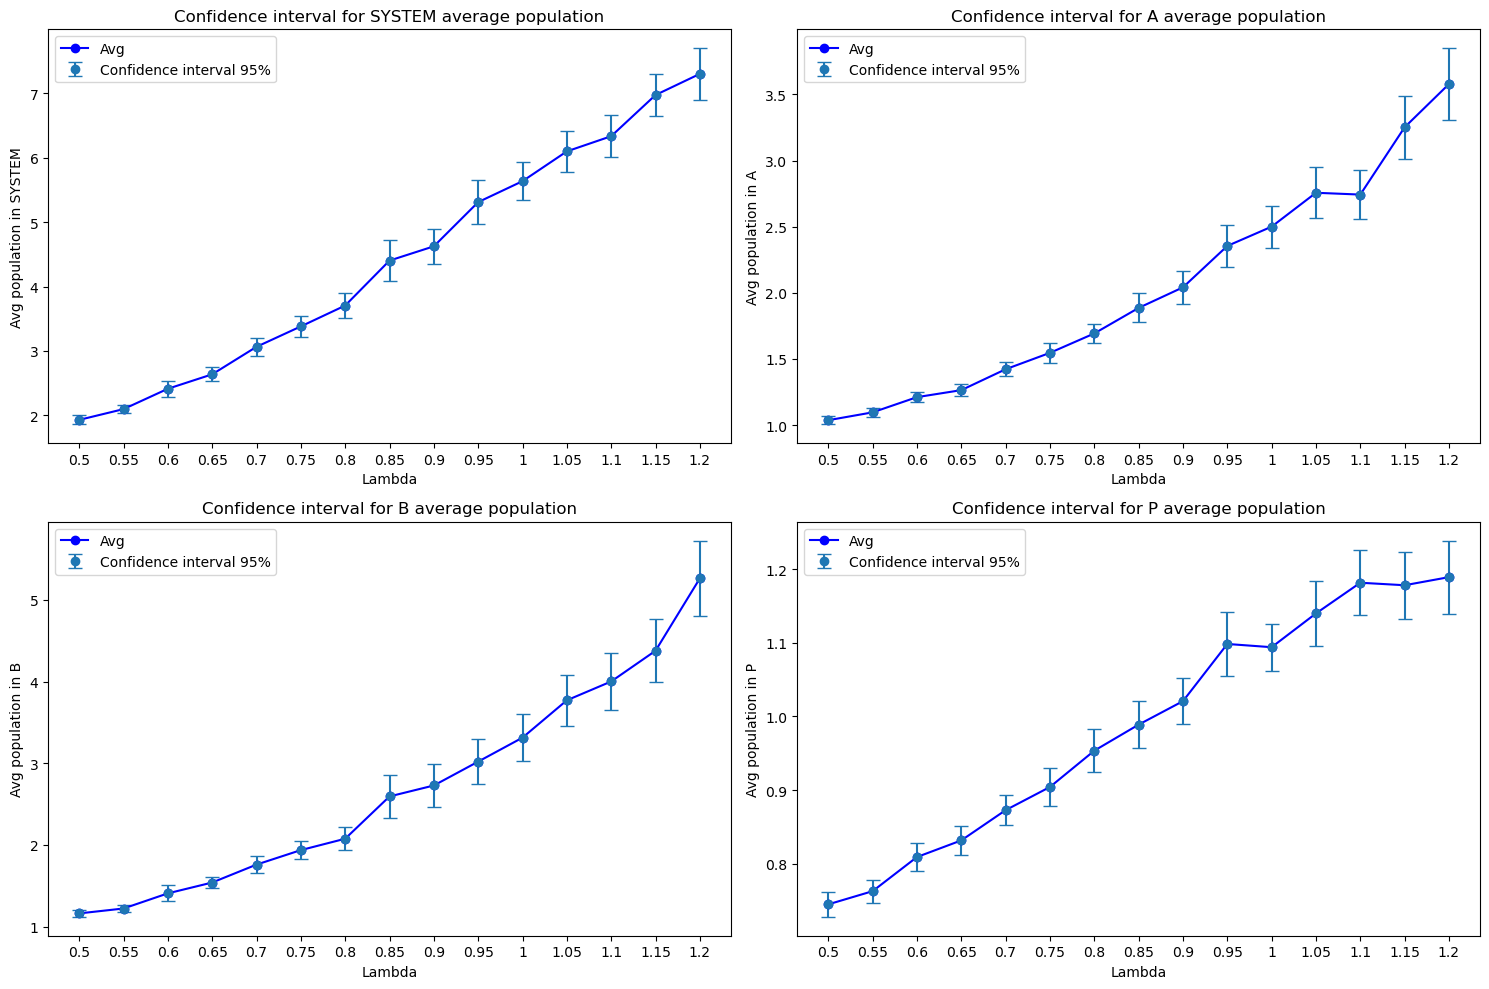

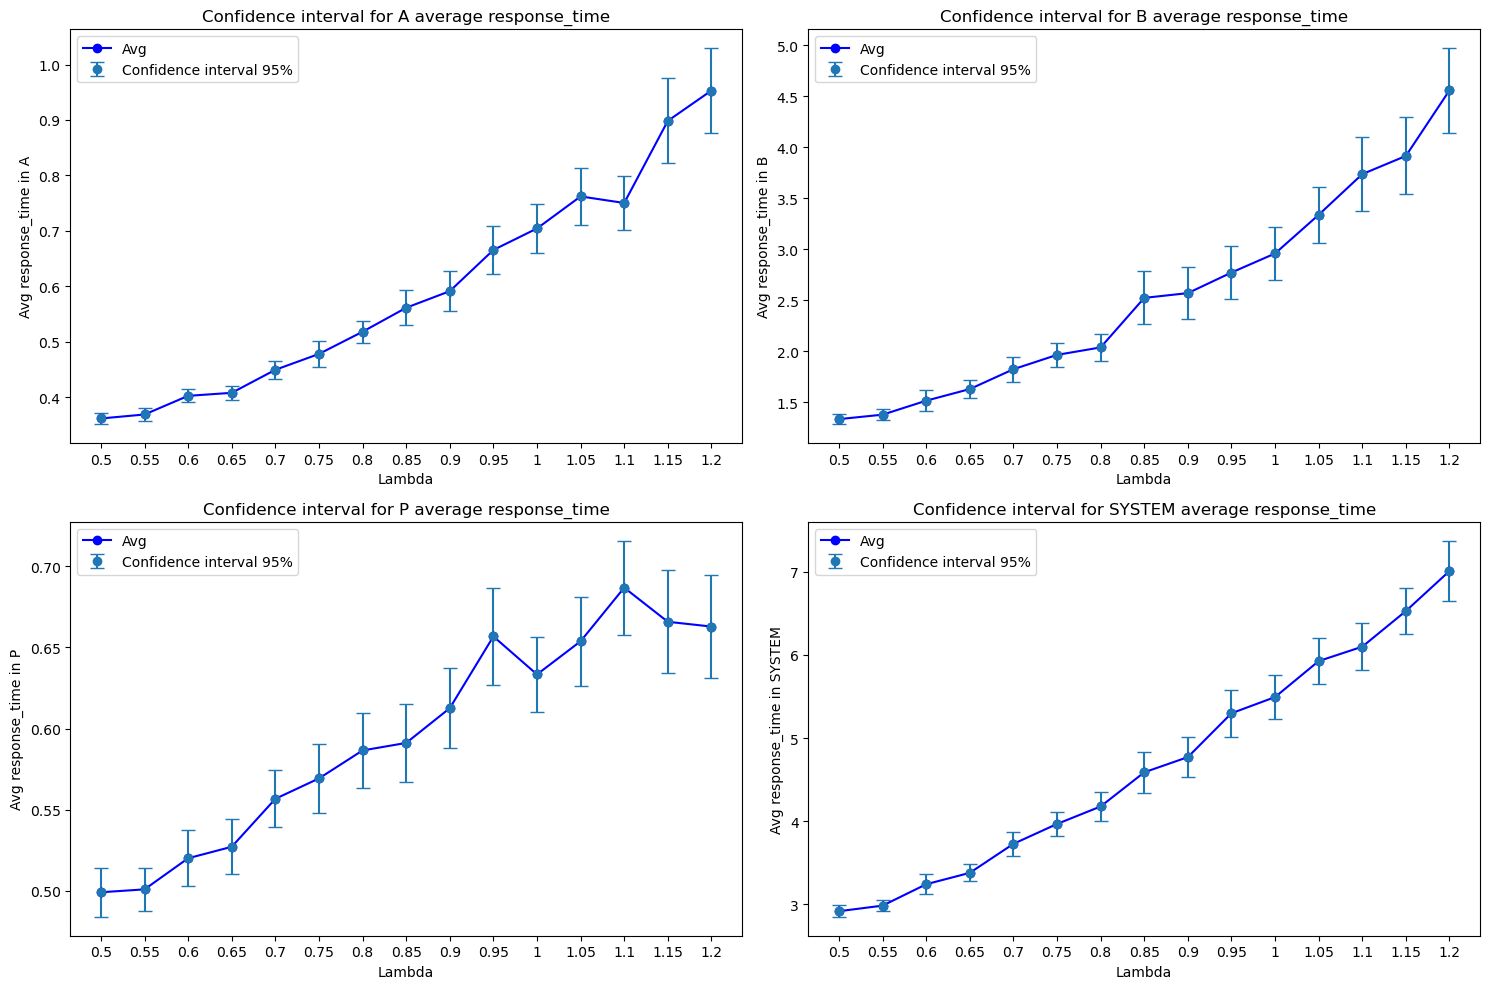

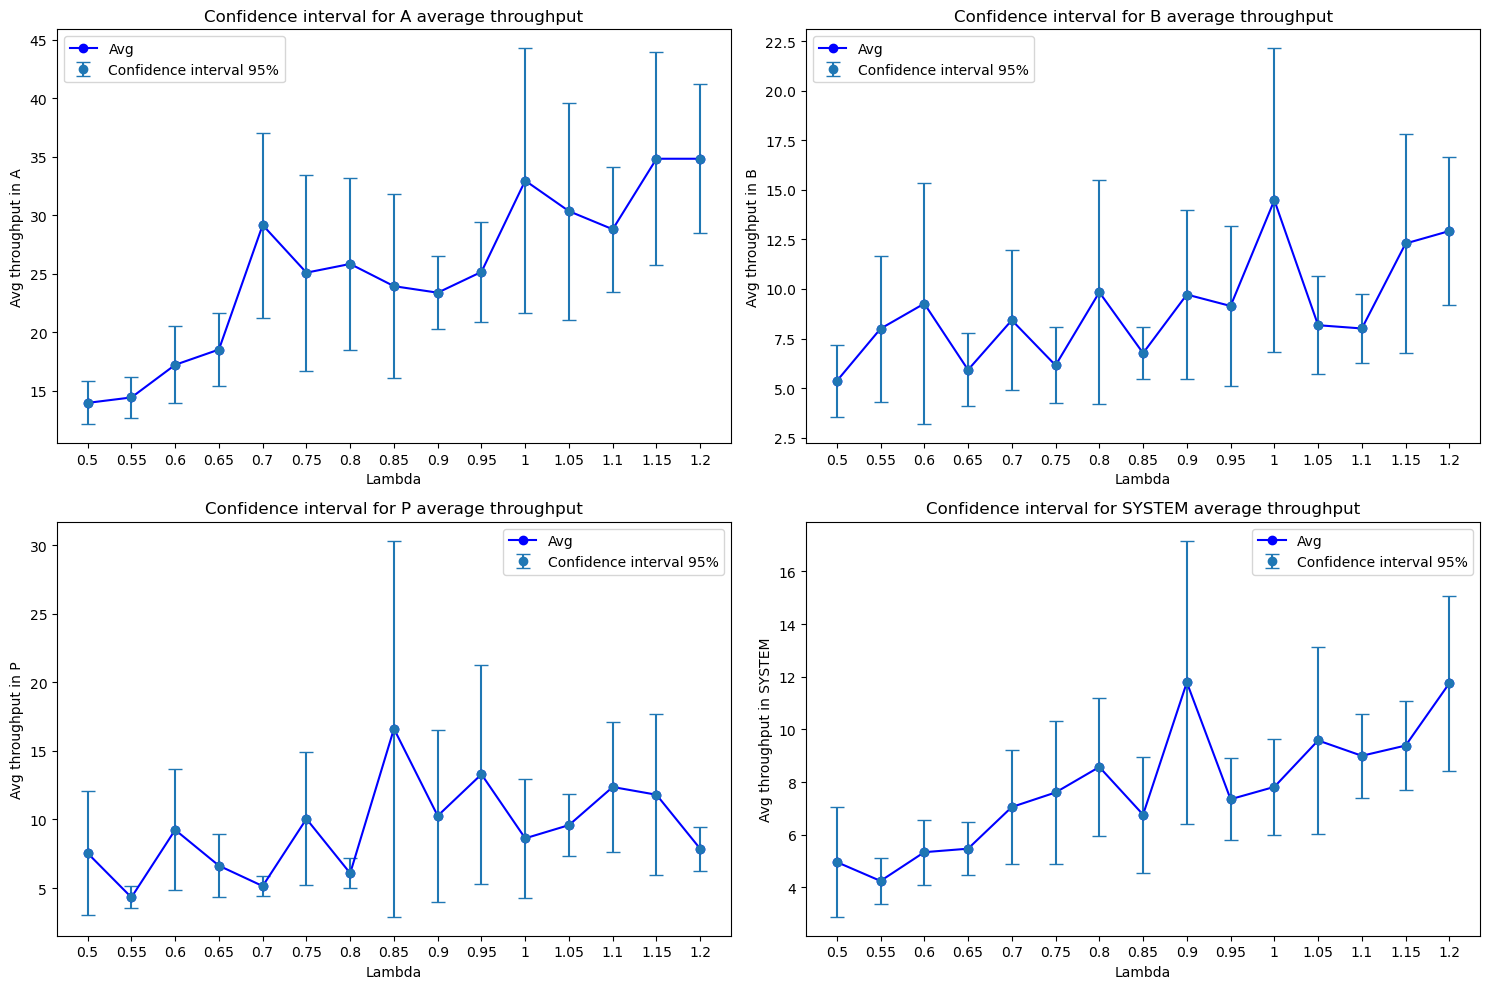

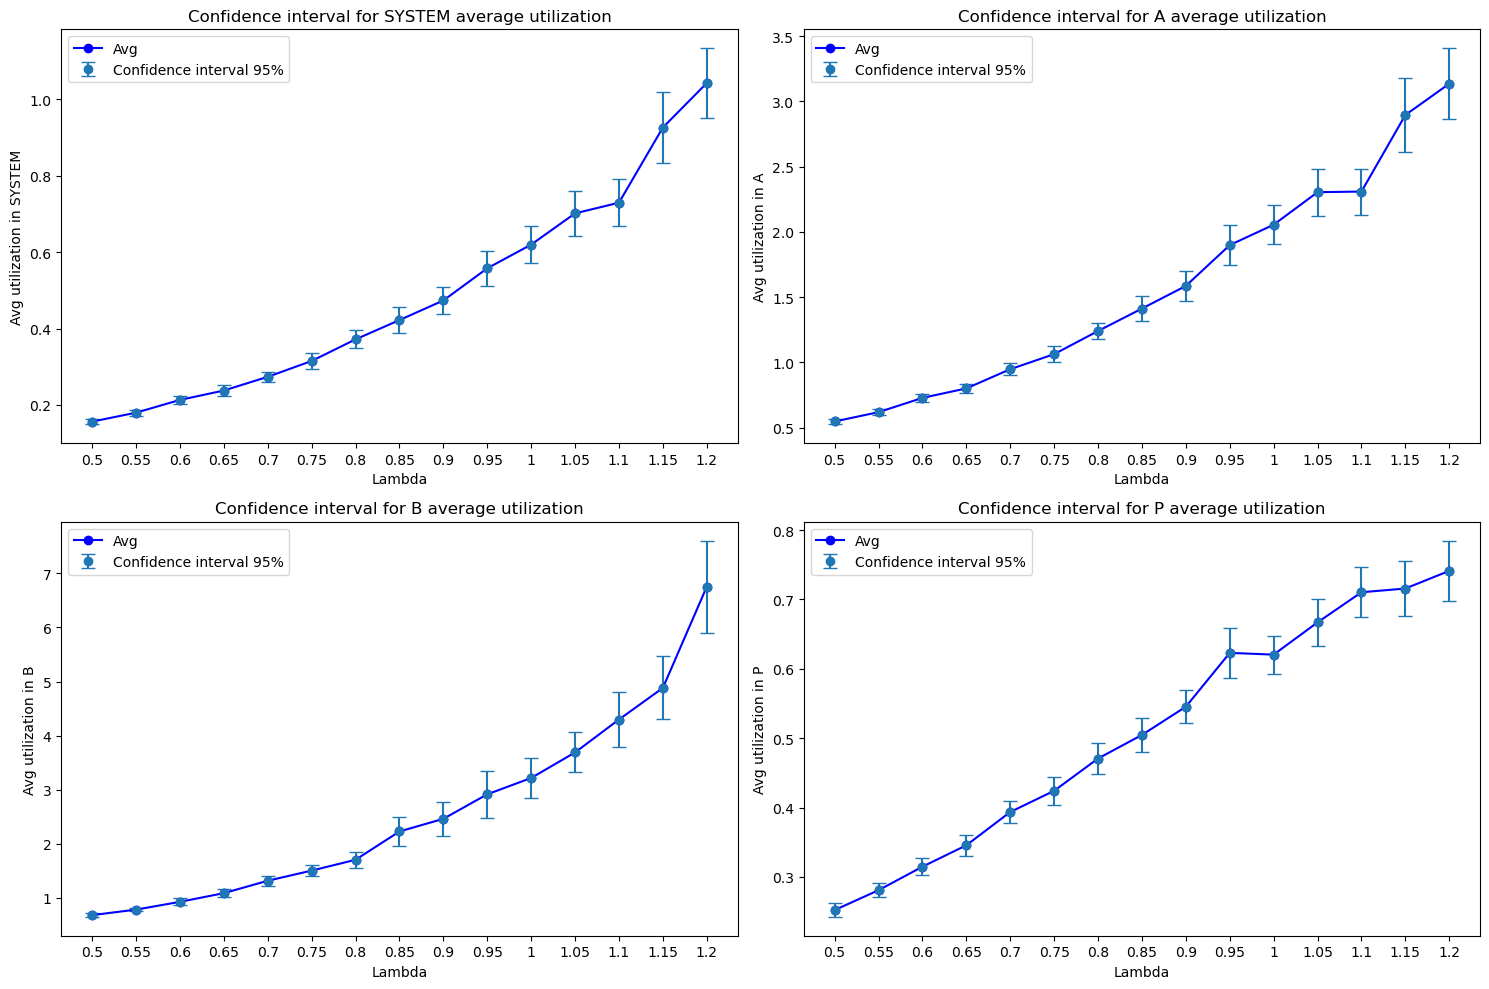

In [25]:
path = os.path.join("..", "..", "src", "caballo", "domestico", "wwsimulator", "statistics", "objective_1")
critical_value = scipy.stats.norm.ppf(1-.05/2)

metrics_nodes_avg_df_list = preprocessing(path, 'obj1')
boxplot(metrics_nodes_avg_df_list)

ci_df = confidence_interval(metrics_nodes_avg_df_list, critical_value, 'obj1')
plot_confidence_interval(ci_df)

## Objective 2

The model adds the functionality of two-factor authentication, observe the three metrics variation.

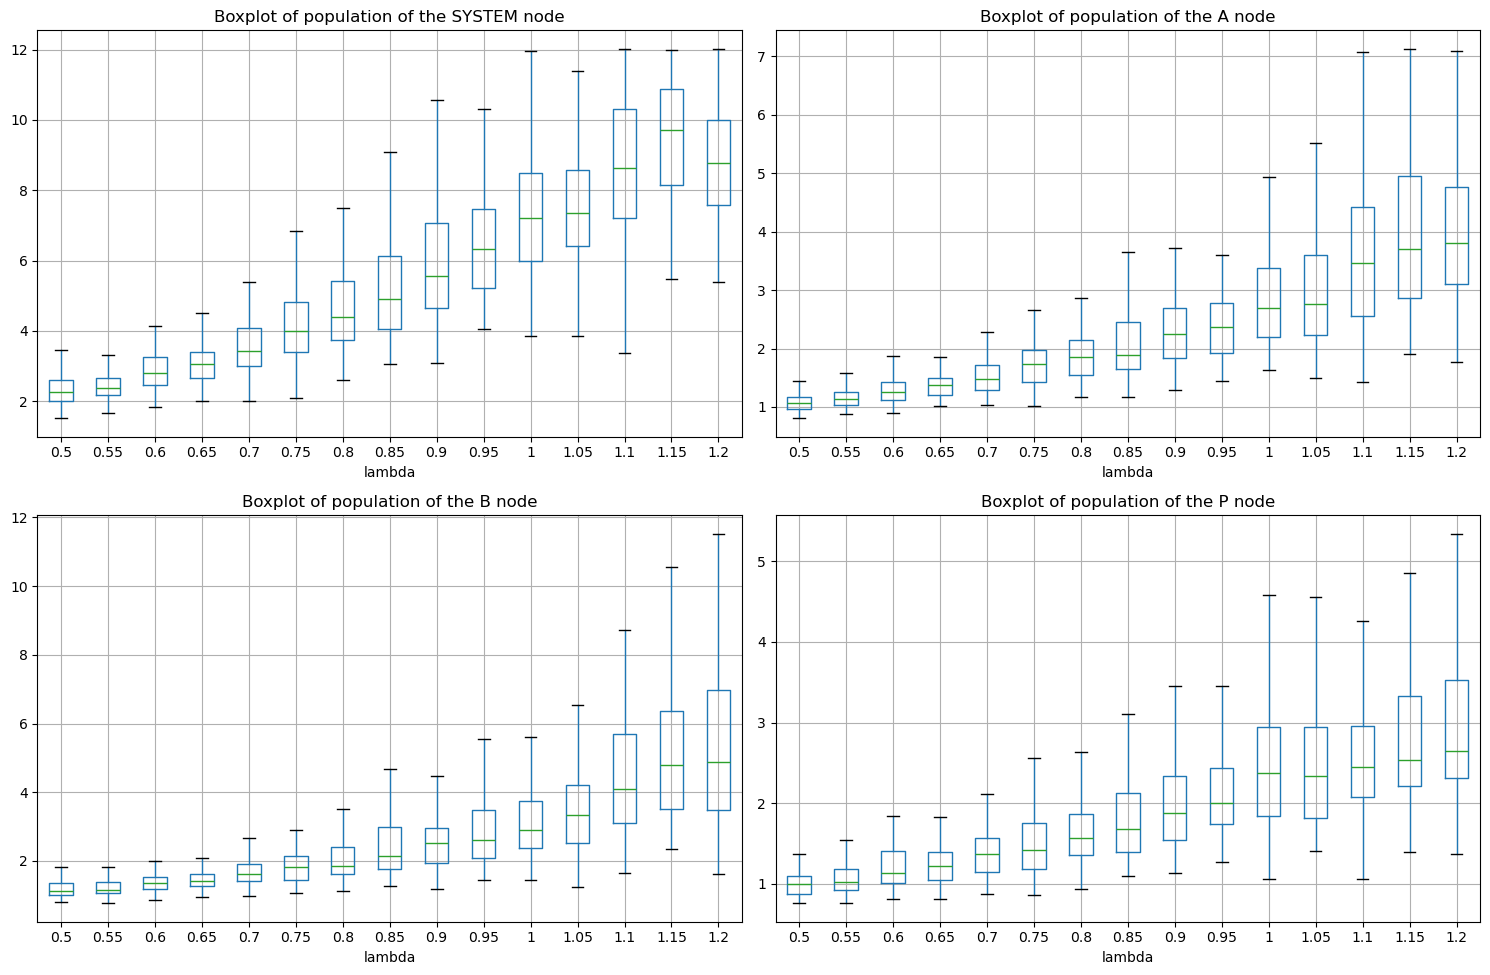

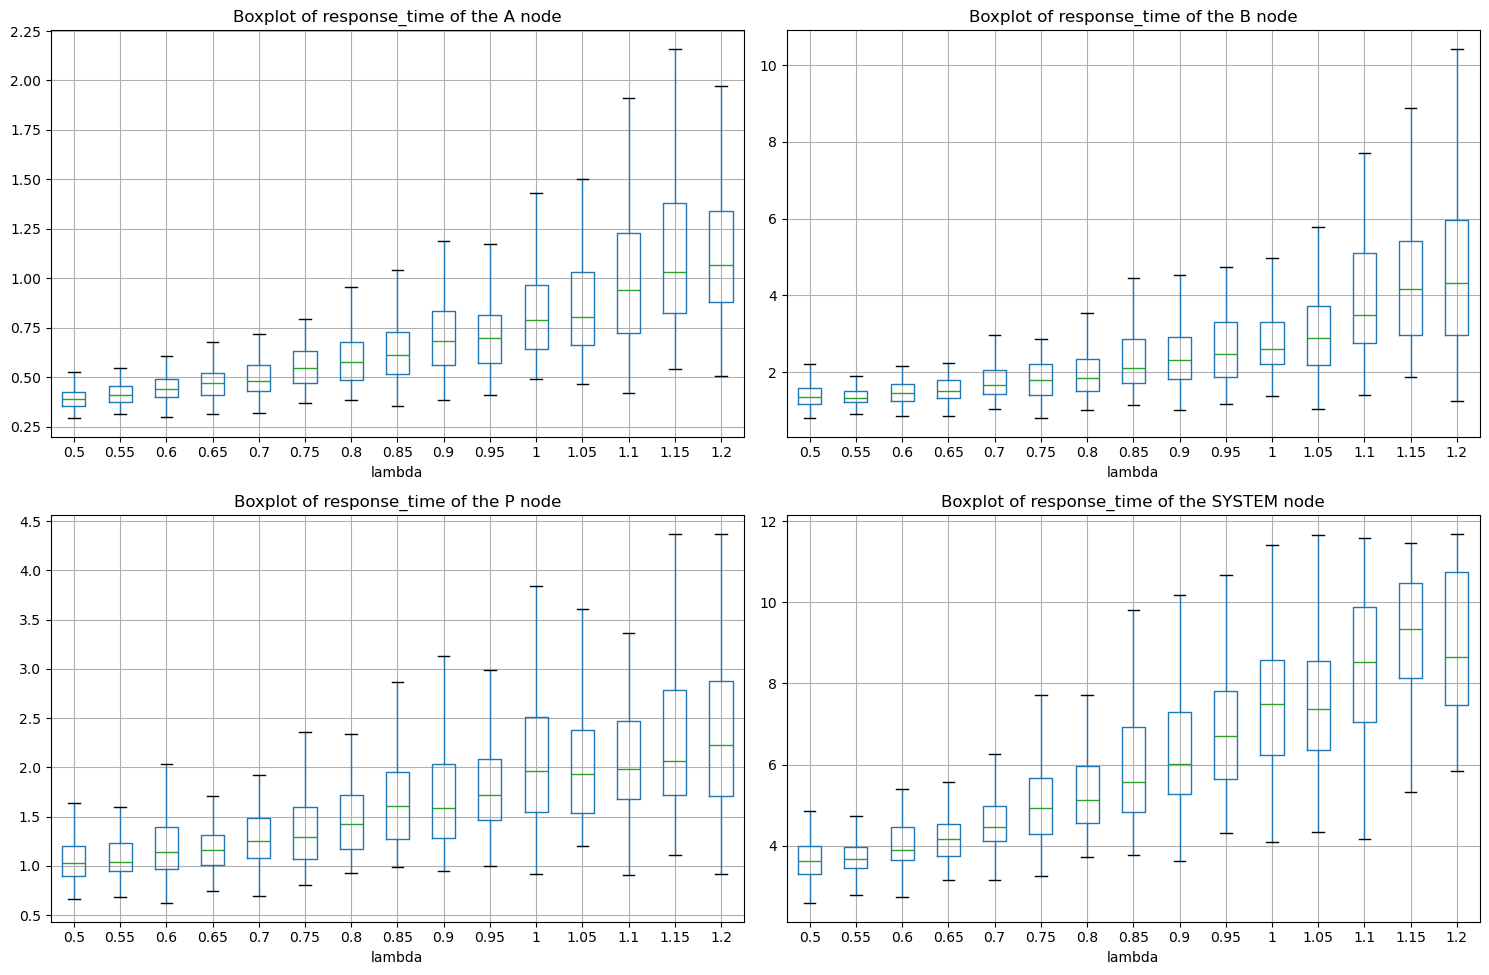

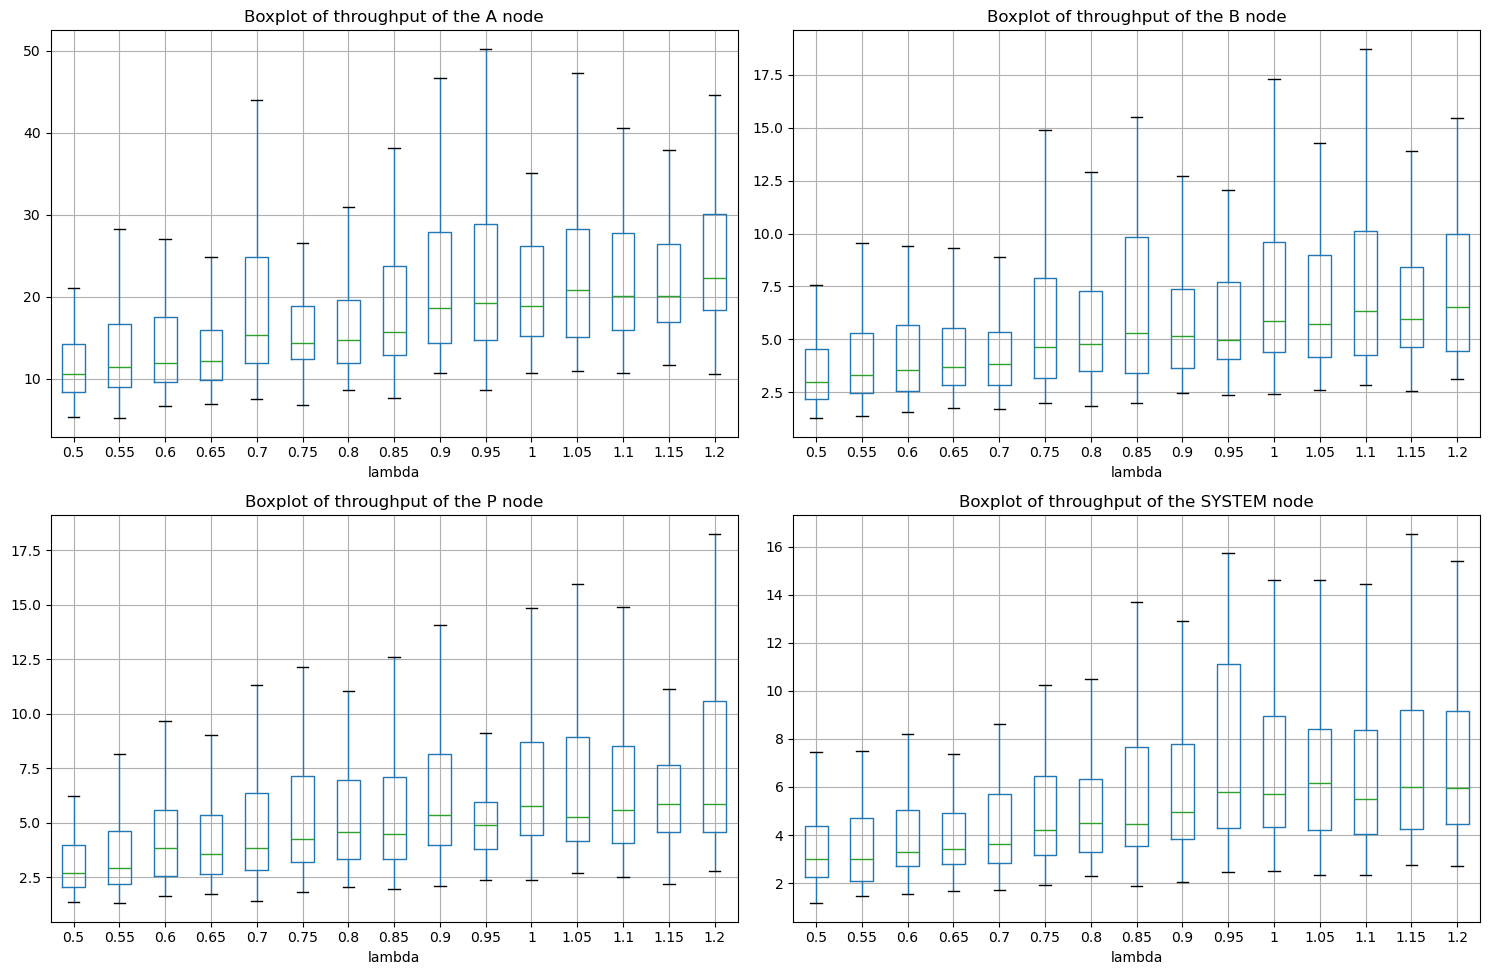

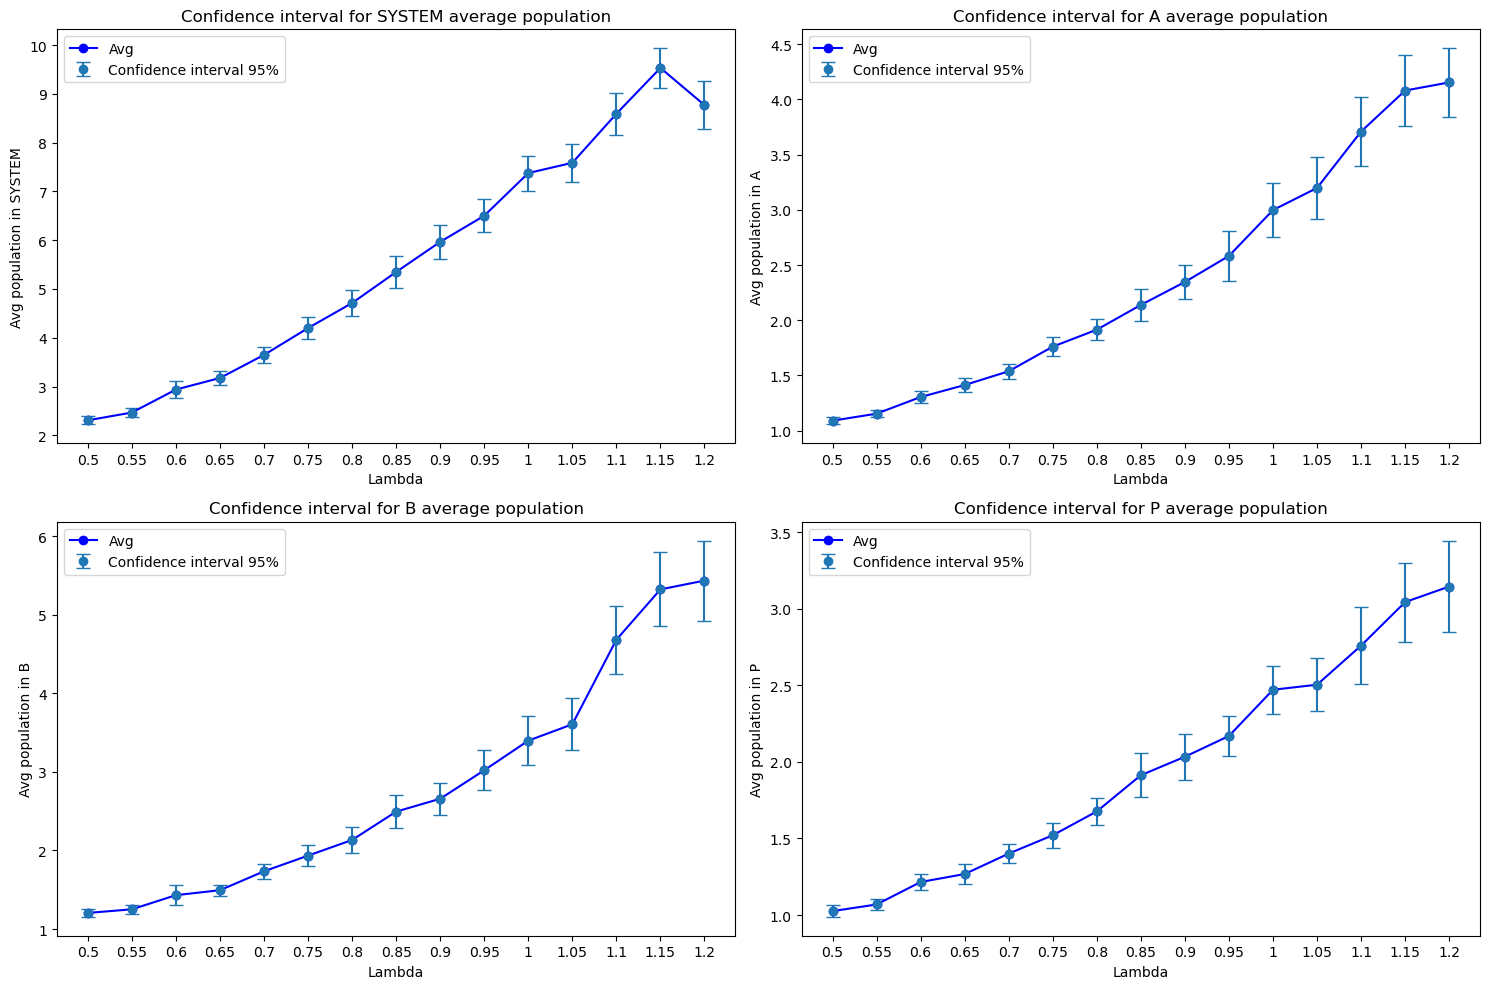

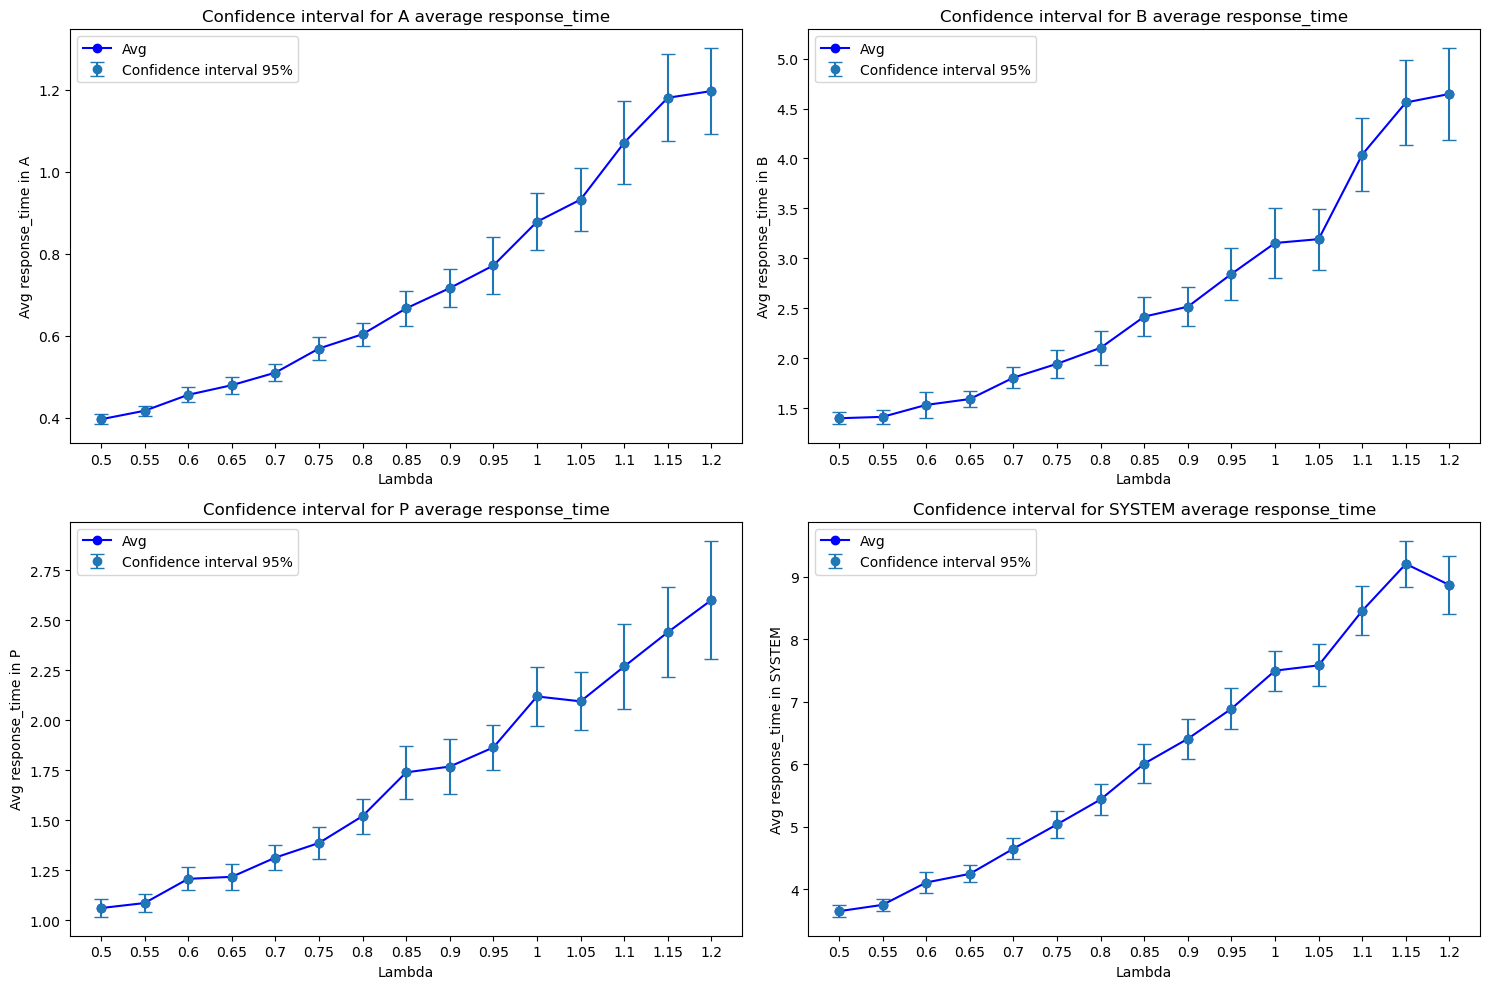

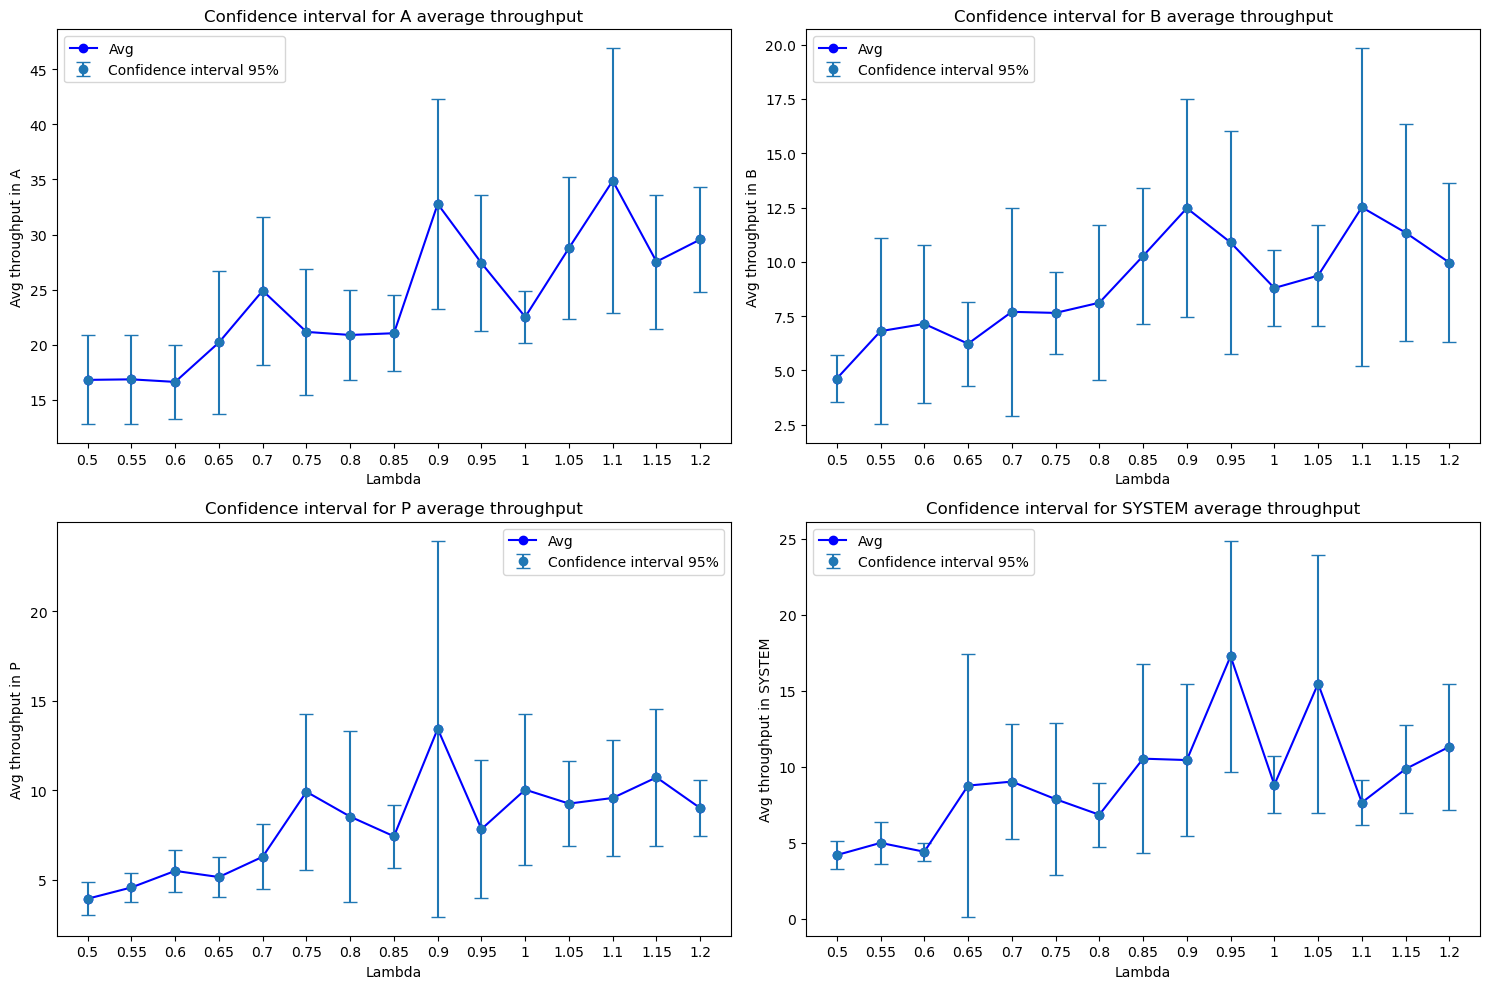

In [126]:
path = os.path.join("..", "..", "src", "caballo", "domestico", "wwsimulator", "statistics", "objective_2")
critical_value = scipy.stats.norm.ppf(1-.05/2)

metrics_nodes_avg_df_list = preprocessing(path, 'obj2')
boxplot(metrics_nodes_avg_df_list)

ci_df = confidence_interval(metrics_nodes_avg_df_list, critical_value, 'obj2')
plot_confidence_interval(ci_df)

## Objective 3

Measure the metrics with an increased workload from 4200 req/h to 5000 req/h

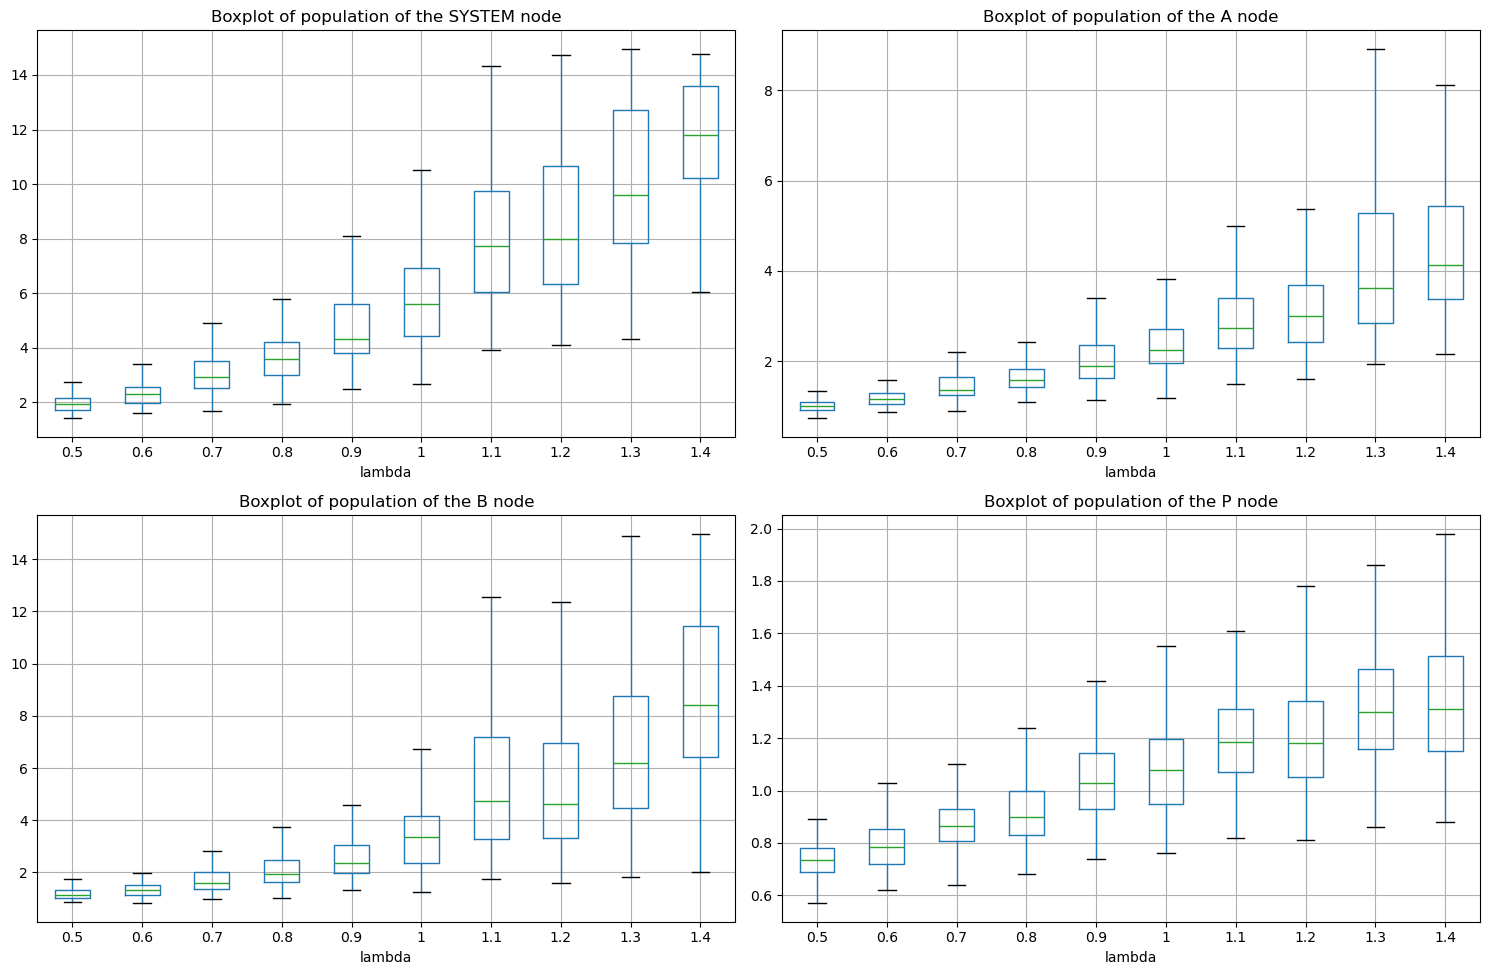

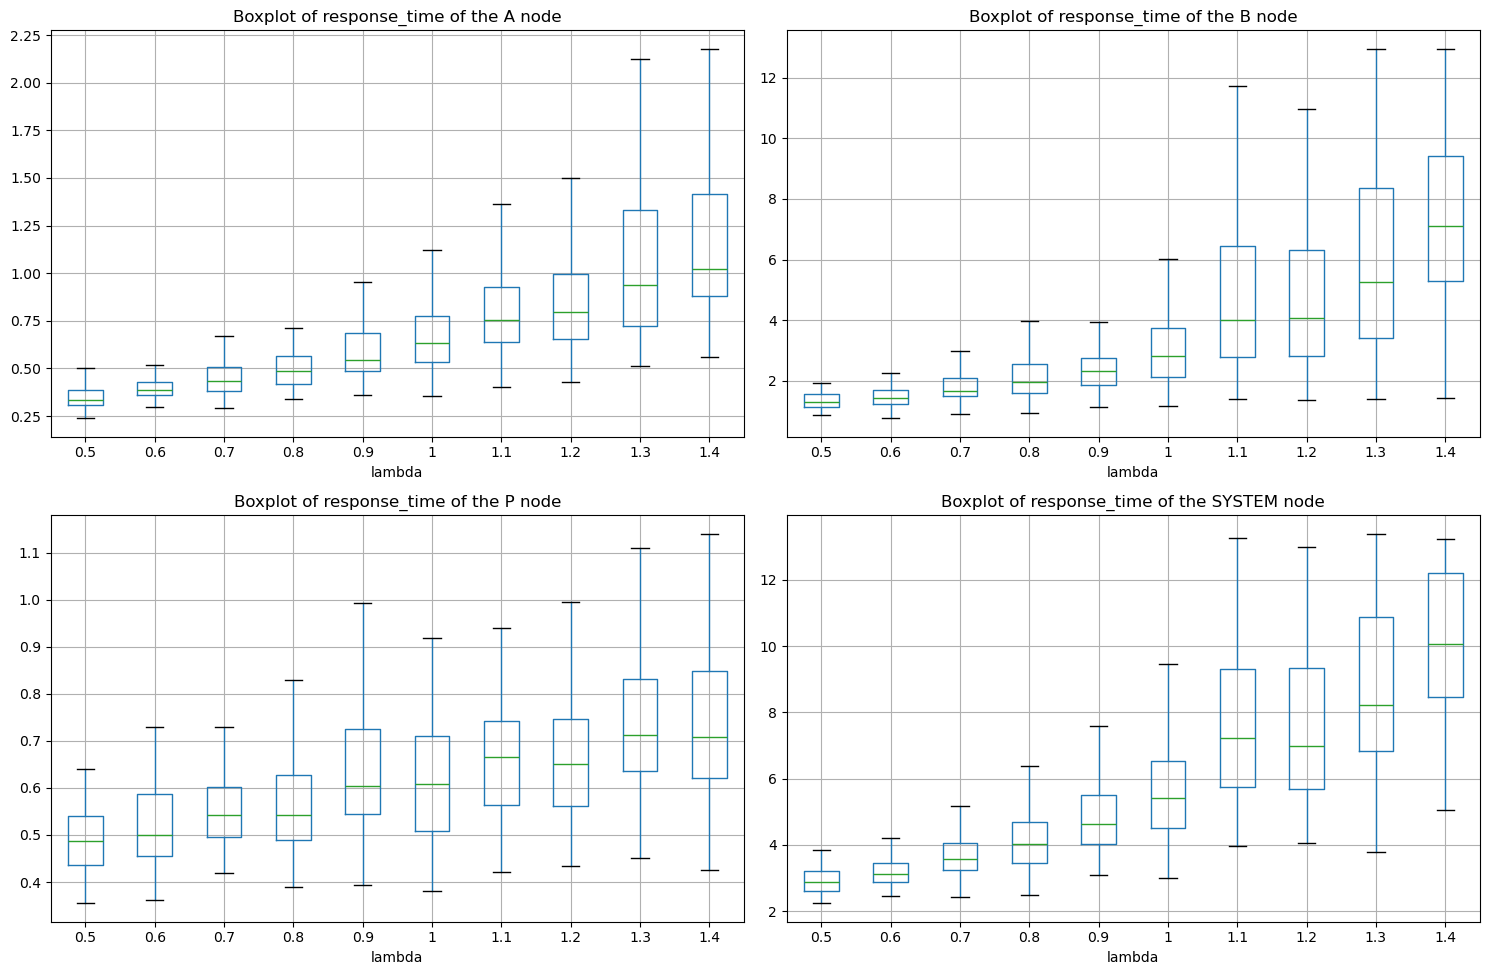

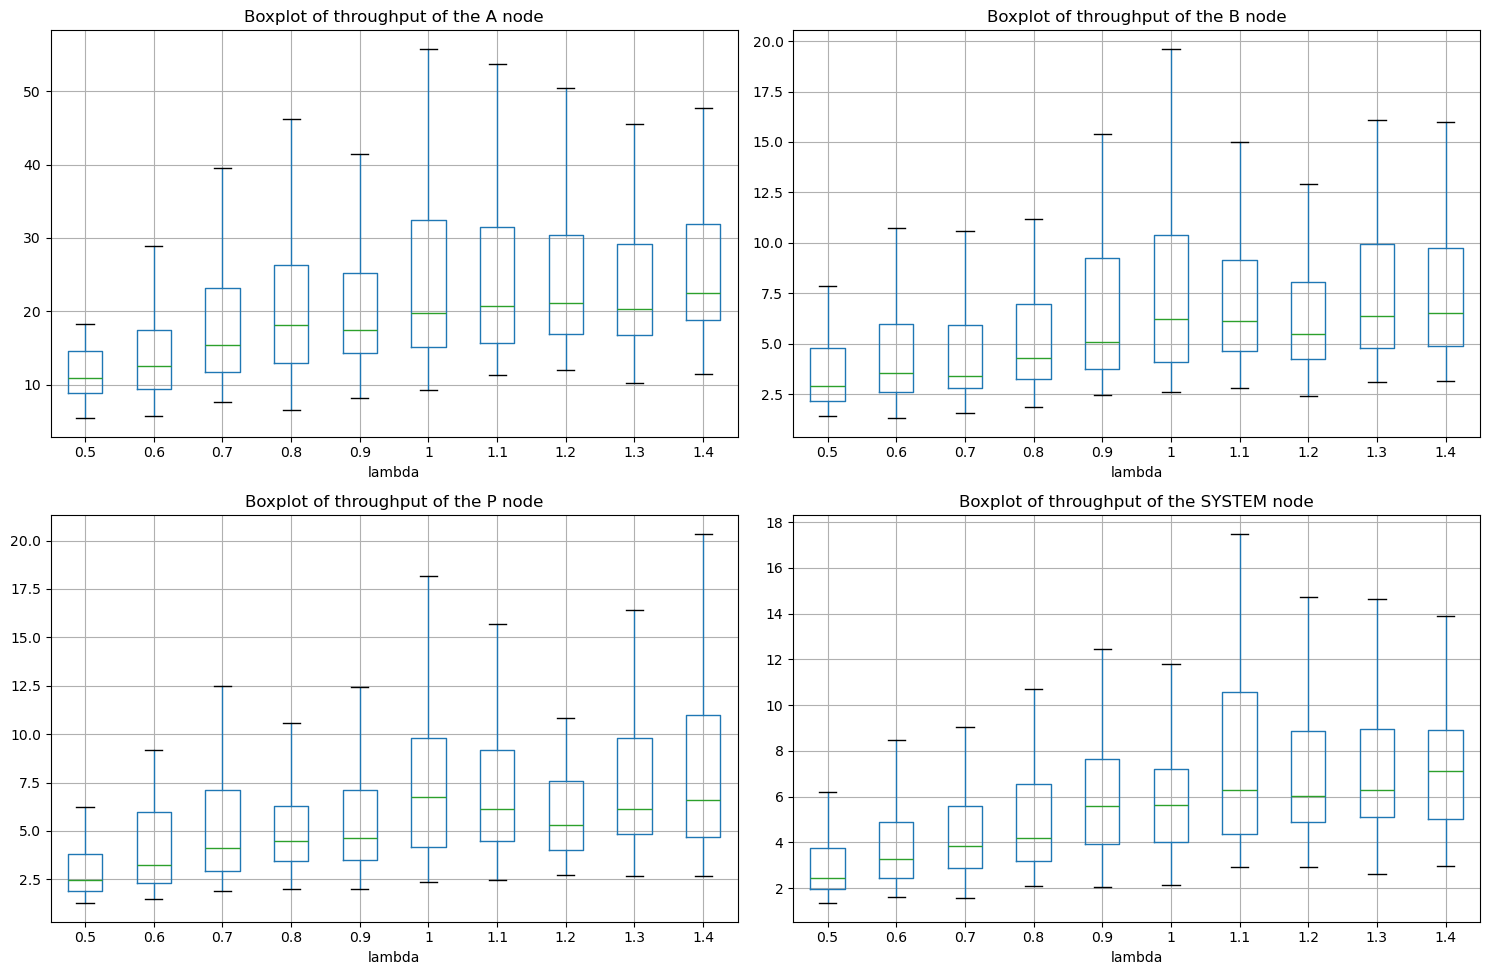

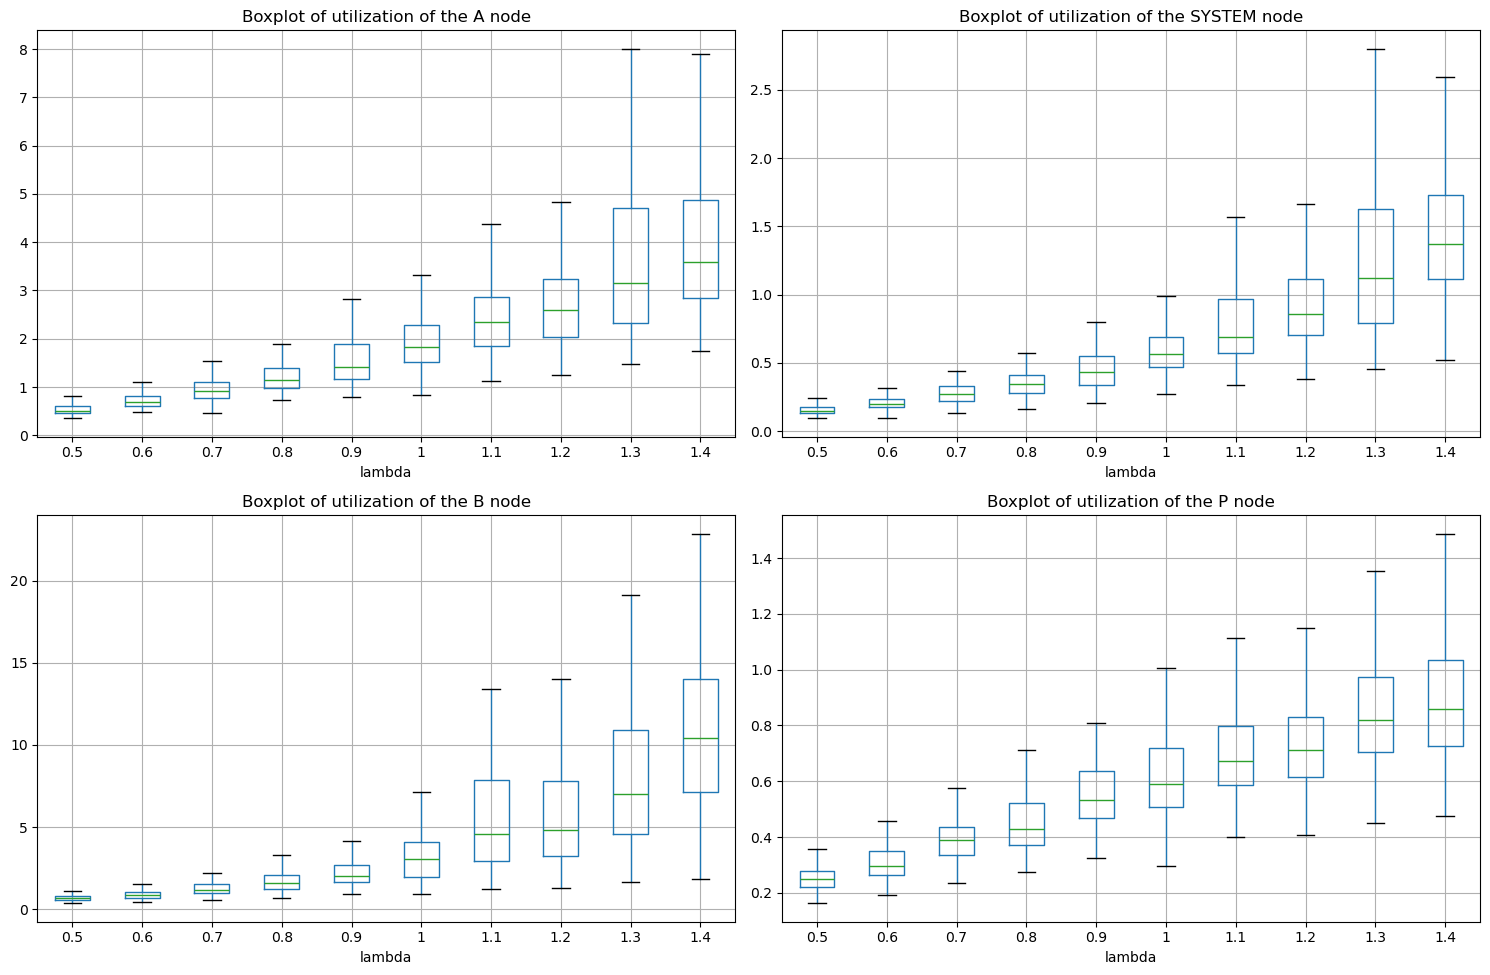

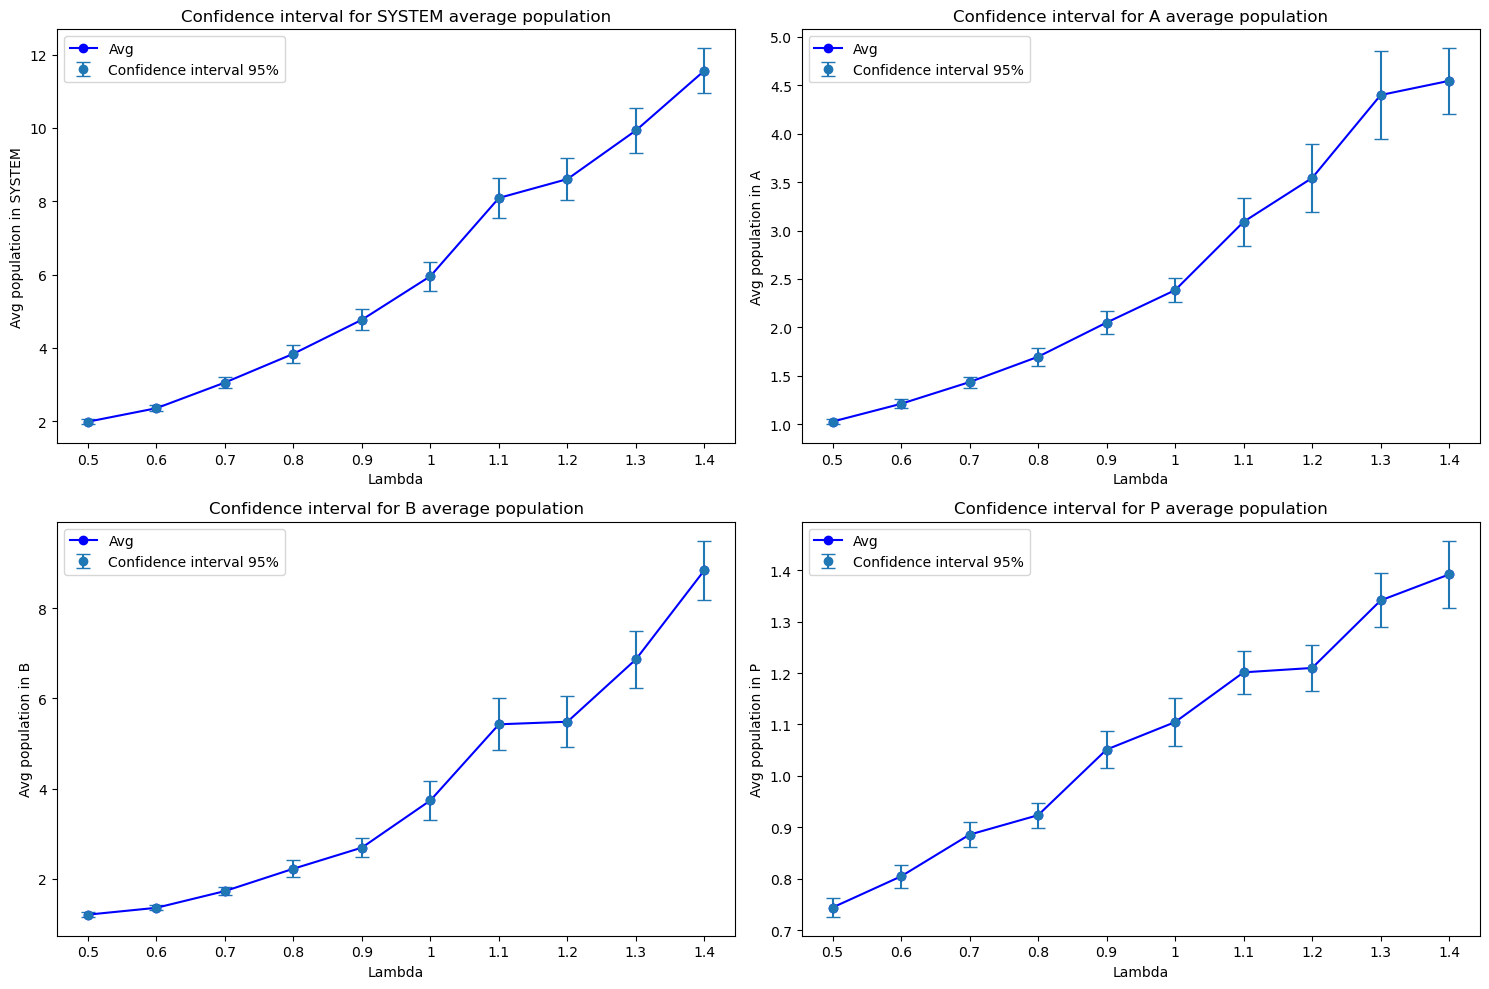

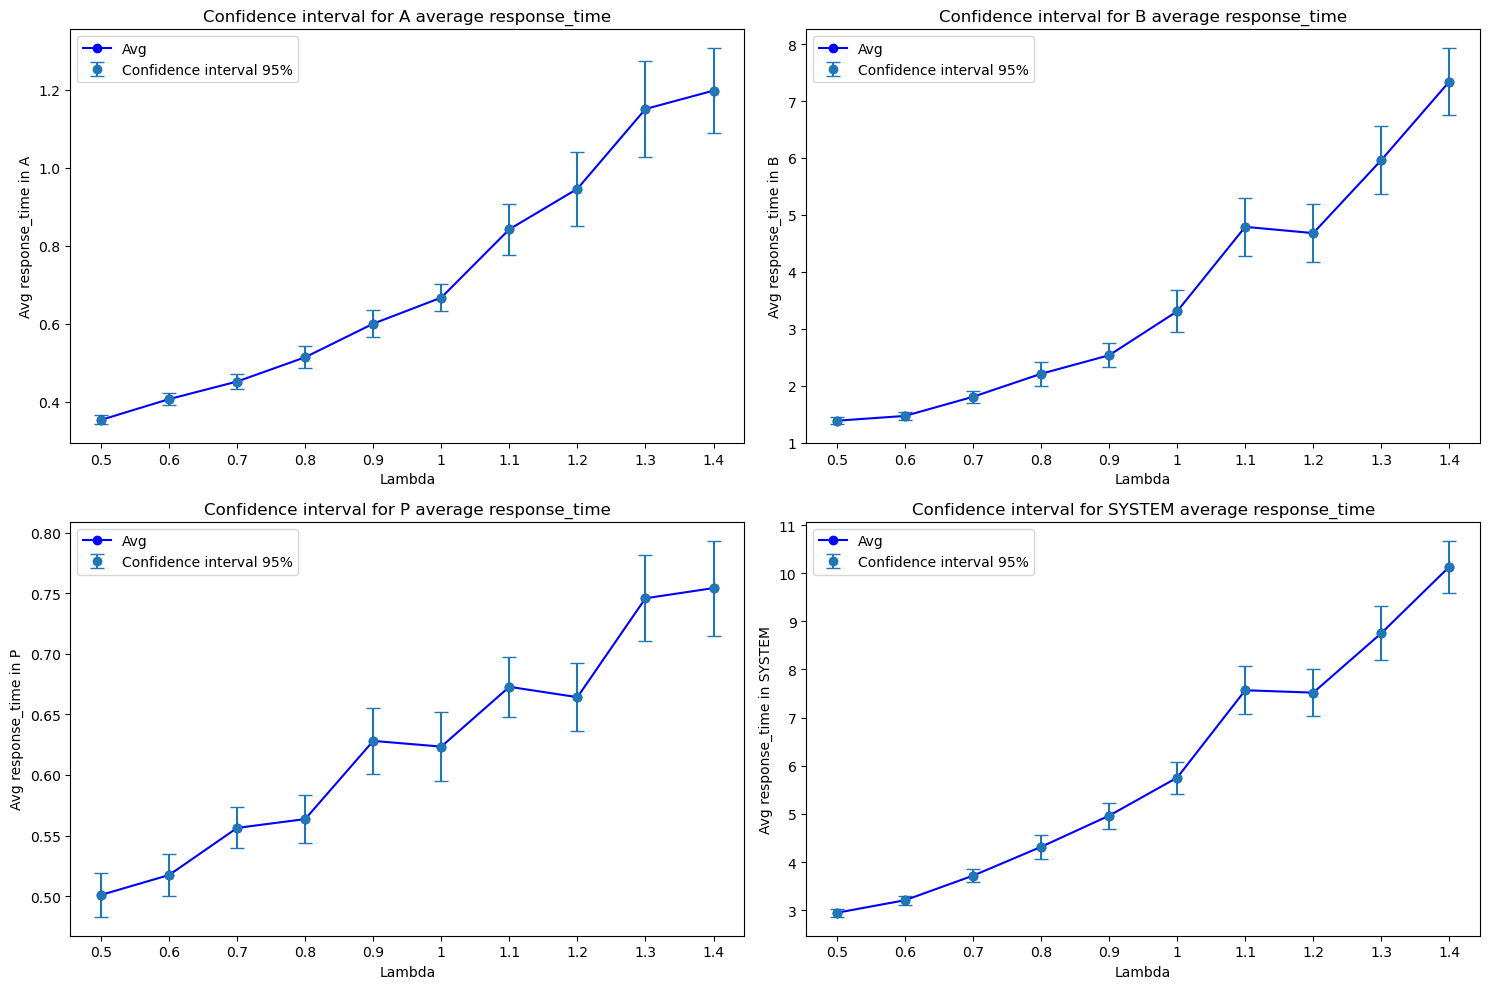

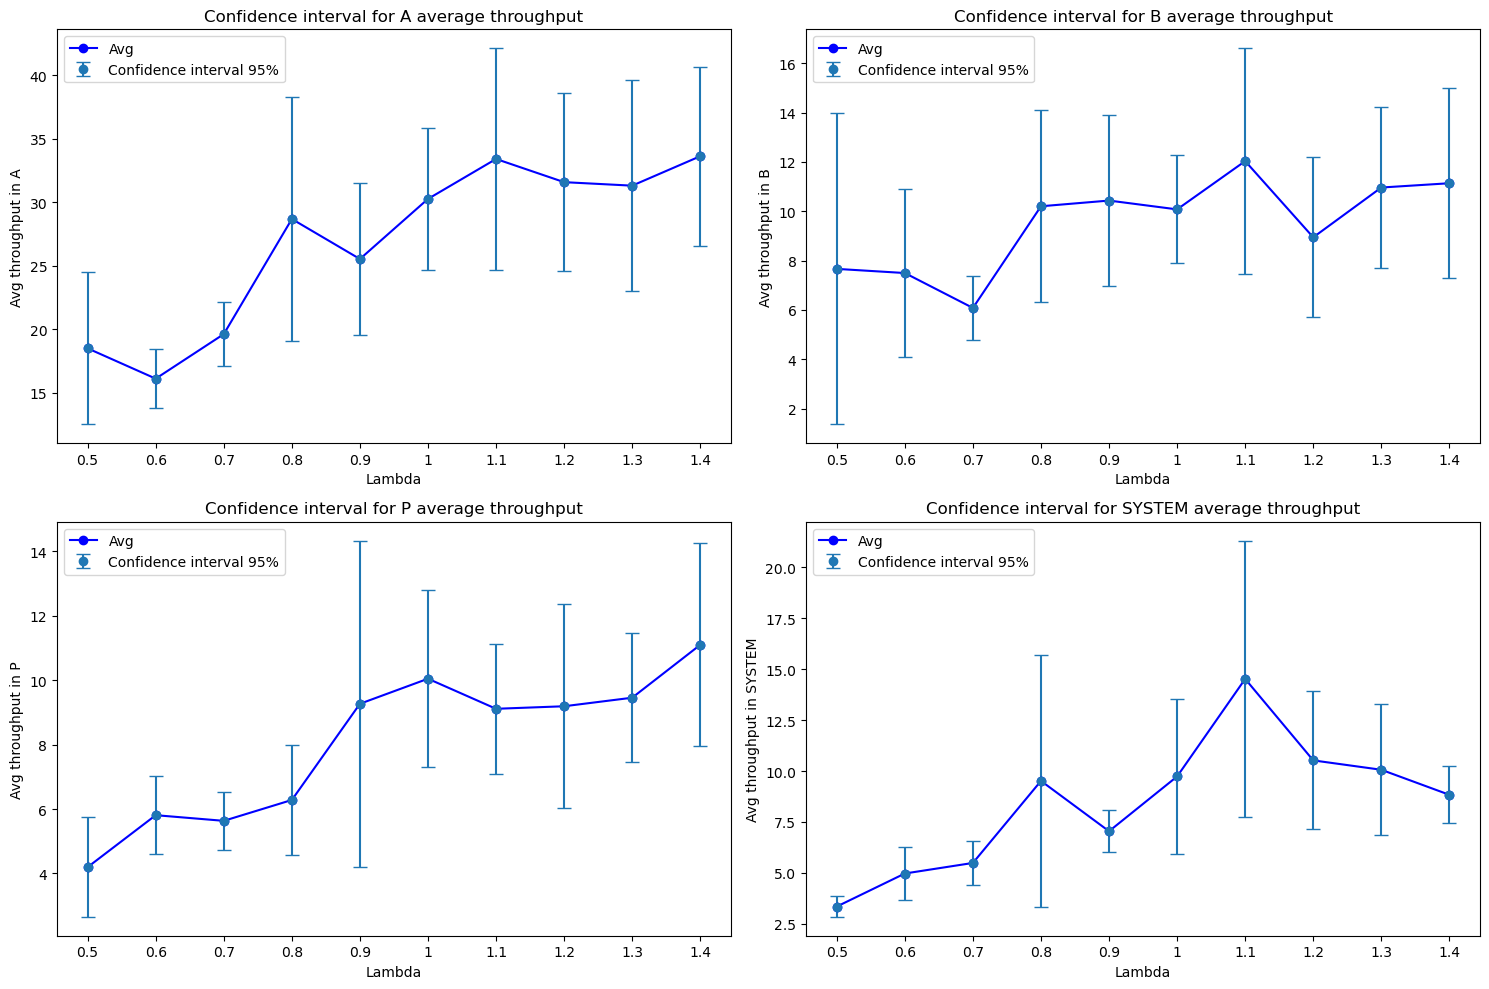

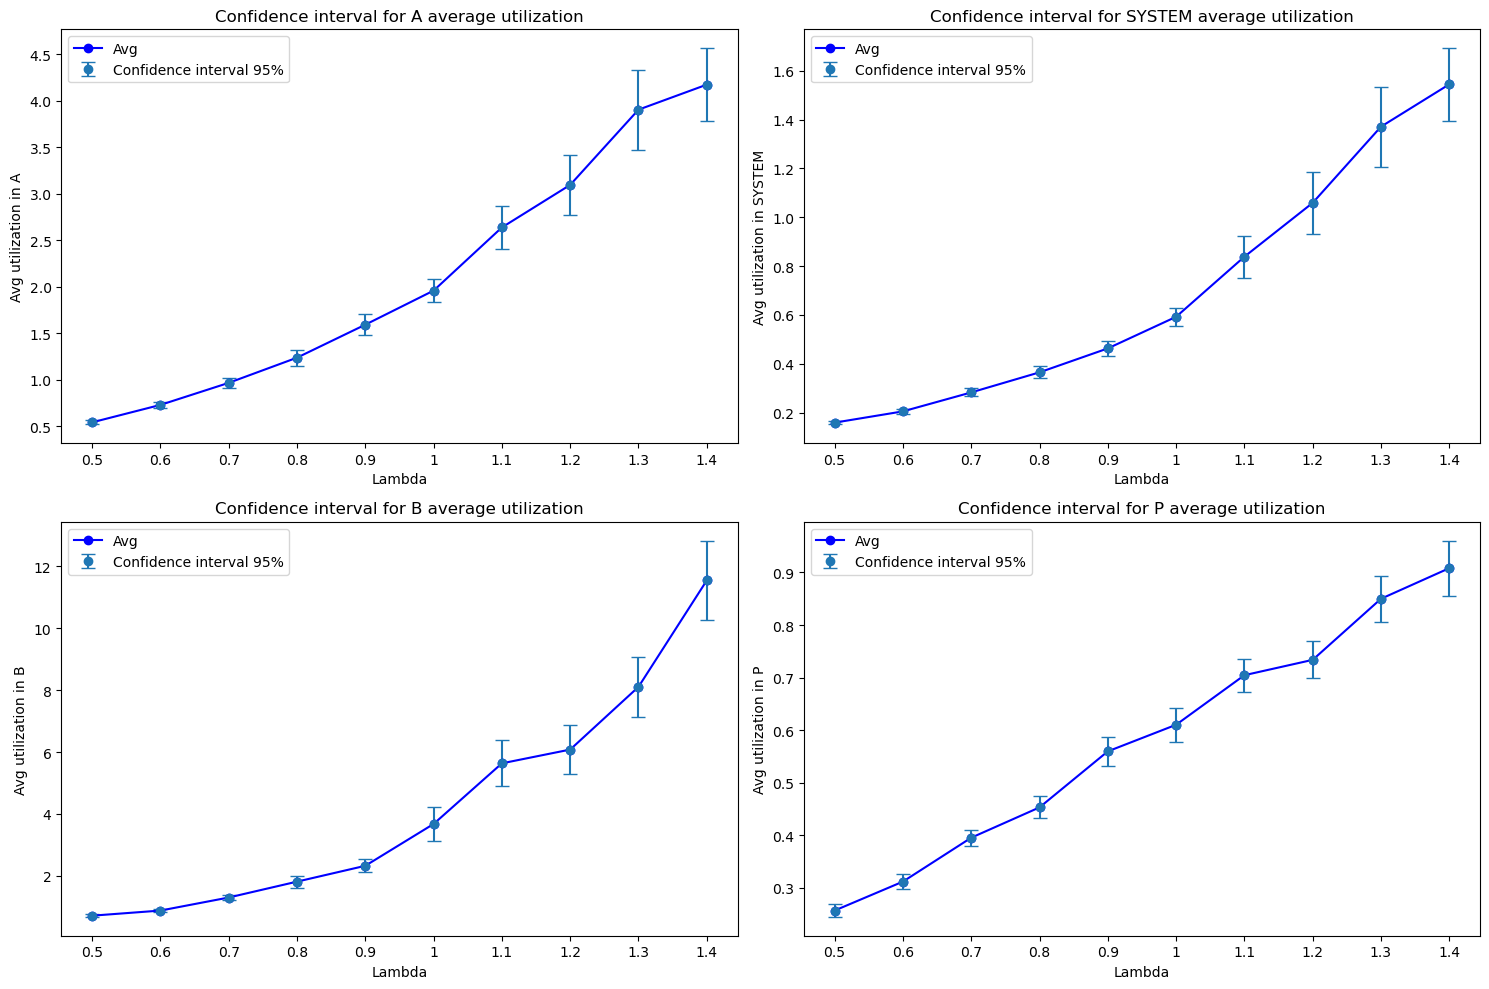

In [26]:
path = os.path.join("..", "..", "src", "caballo", "domestico", "wwsimulator", "statistics", "objective_3")
critical_value = scipy.stats.norm.ppf(1-.05/2)

metrics_nodes_avg_df_list = preprocessing(path, 'obj3')
boxplot(metrics_nodes_avg_df_list)

ci_df = confidence_interval(metrics_nodes_avg_df_list, critical_value, 'obj3')
plot_confidence_interval(ci_df)